Описание данных:
  ptbxl_database.csv - исходный датасет для анализа. 
  Основные атрибуты: возраст, пол, рост, вес, код диагноза и подклассы диагнозов

  scp_statements.csv - словарь кодов диагнозов с подклассами.

Значения классов:

NORM: Нормальная ЭКГ

MI: Инфаркт миокарда, инфаркт миокарда (ИМ), широко известный как сердечный приступ, возникает, когда поток крови уменьшается или прекращается в части сердца, вызывая повреждение сердечной мышцы.

STTC: Изменение ST/T. Изменения зубцов ST и T могут указывать на сердечную патологию или быть вариантом нормы. Таким образом, интерпретация результатов зависит от клинического контекста и наличия аналогичных результатов на предыдущих электрокардиограммах.

CD: Conduction Disturbance. Ваш сердечный ритм – это то, как бьется ваше сердце. Проводимость – это то, как электрические импульсы проходят через ваше сердце, заставляя его биться. Некоторые нарушения проводимости могут вызывать аритмии или нерегулярное сердцебиение.

HYP: Гипертрофия. Гипертрофическая кардиомиопатия (ГКМП) — заболевание, при котором сердечная мышца становится аномально толстой (гипертрофированной). Утолщенная сердечная мышца может затруднить перекачку крови сердцу.

In [1]:
!pip install wfdb

In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = './dataset/'
sampling_rate=500

# Загрузка аннотационных данных
df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))



In [6]:
df.describe(include='all')

patient_id           age           sex       height       weight  \
count   21799.000000  21799.000000  21799.000000  6974.000000  9421.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN           NaN           NaN          NaN          NaN   
mean    11250.156521     62.769301      0.479150   166.702323    70.995223   
std      6235.026404     32.308813      0.499577    10.867321    15.878803   
min       302.000000      2.000000      0.000000     6.000000     5.000000   
25%      5974.500000     50.000000      0.000000   160.000000    60.000000   
50%     11419.000000     62.000000      0.000000   166.000000    70.000000   
75%     16607.500000     72.000000      1.000000   174.000000    80.000000   
max     21797.000000    300.000000      1.000000   209.000000   250.000000   

               nurse          site      device       recording_date  \
count   20326.000000  21782.000000       21799                21799   
unique           NaN           NaN          11                21795   
top              NaN           NaN  CS100    3  1992-02-06 11:47:42   
freq             NaN           NaN        6140                    2   
mean        2.291745      1.544945         NaN                  NaN   
std         3.254033      4.172883         NaN                  NaN   
min         0.000000      0.000000         NaN                  NaN   
25%         0.000000      0.000000         NaN                  NaN   
50%         1.000000      1.000000         NaN                  NaN   
75%         3.000000      2.000000         NaN                  NaN   
max        11.000000     50.000000         NaN                  NaN   

                           report  ... validated_by_human baseline_drift  \
count                       21799  ...              21799           1598   
unique                       9887  ...                  2            317   
top     sinus rhythm. normal ecg.  ...               True           , V6   
freq                         1734  ...              16056            221   
mean                          NaN  ...                NaN            NaN   
std                           NaN  ...                NaN            NaN   
min                           NaN  ...                NaN            NaN   
25%                           NaN  ...                NaN            NaN   
50%                           NaN  ...                NaN            NaN   
75%                           NaN  ...                NaN            NaN   
max                           NaN  ...                NaN            NaN   

       static_noise burst_noise  electrodes_problems extra_beats  \
count          3260         613                   30        1949   
unique          124         103                   14         128   
top      , I-AVR,         alles                   V6         1ES   
freq            953         140                    8         405   
mean            NaN         NaN                  NaN         NaN   
std             NaN         NaN                  NaN         NaN   
min             NaN         NaN                  NaN         NaN   
25%             NaN         NaN                  NaN         NaN   
50%             NaN         NaN                  NaN         NaN   
75%             NaN         NaN                  NaN         NaN   
max             NaN         NaN                  NaN         NaN   

            pacemaker    strat_fold                filename_lr  \
count             291  21799.000000                      21799   
unique              4           NaN                      21799   
top     ja, pacemaker           NaN  records100/00000/00001_lr   
freq              285           NaN                          1   
mean              NaN      5.503005                        NaN   
std               NaN      2.874948                        NaN   
min               NaN      1

In [8]:
def remove_outliers(data, col):
    column = data[col]
    IQR = column.quantile(0.75) - column.quantile(0.25)
    h = column.quantile(0.75) + 1.5 * IQR
    l = column.quantile(0.25) - 1.5 * IQR
    return data[column.between(l, h)]
    
def remove_outer_interval(data, col, low_value, max_value):
    column = data[col]
    return data[column.between(low_value, max_value)]    

In [9]:
df = remove_outer_interval(df, "age", 5, 100)

In [13]:
df.describe(include='all')

patient_id           age           sex       height       weight  \
count   21501.000000  21501.000000  21501.000000  6812.000000  9263.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN           NaN           NaN          NaN          NaN   
mean    11289.710665     59.550346      0.475141   166.860393    71.249703   
std      6224.143201     16.738679      0.499393    10.773875    15.772341   
min       302.000000      5.000000      0.000000     6.000000     5.000000   
25%      6053.000000     50.000000      0.000000   160.000000    60.000000   
50%     11466.000000     61.000000      0.000000   166.000000    70.000000   
75%     16636.000000     72.000000      1.000000   174.000000    80.000000   
max     21797.000000     89.000000      1.000000   209.000000   250.000000   

               nurse          site      device       recording_date  \
count   20056.000000  21486.000000       21501                21501   
unique           NaN           NaN          11                21497   
top              NaN           NaN  CS100    3  2000-08-08 09:34:05   
freq             NaN           NaN        6133                    2   
mean        2.270193      1.533976         NaN                  NaN   
std         3.246346      4.170682         NaN                  NaN   
min         0.000000      0.000000         NaN                  NaN   
25%         0.000000      0.000000         NaN                  NaN   
50%         1.000000      1.000000         NaN                  NaN   
75%         3.000000      2.000000         NaN                  NaN   
max        11.000000     50.000000         NaN                  NaN   

                           report  ... validated_by_human baseline_drift  \
count                       21501  ...              21501           1570   
unique                       9670  ...                  2            312   
top     sinus rhythm. normal ecg.  ...               True           , V6   
freq                         1728  ...              15761            216   
mean                          NaN  ...                NaN            NaN   
std                           NaN  ...                NaN            NaN   
min                           NaN  ...                NaN            NaN   
25%                           NaN  ...                NaN            NaN   
50%                           NaN  ...                NaN            NaN   
75%                           NaN  ...                NaN            NaN   
max                           NaN  ...                NaN            NaN   

       static_noise burst_noise  electrodes_problems extra_beats  \
count          3215         603                   29        1898   
unique          122         102                   14         128   
top      , I-AVR,         alles                   V6         1ES   
freq            941         140                    8         390   
mean            NaN         NaN                  NaN         NaN   
std             NaN         NaN                  NaN         NaN   
min             NaN         NaN                  NaN         NaN   
25%             NaN         NaN                  NaN         NaN   
50%             NaN         NaN                  NaN         NaN   
75%             NaN         NaN                  NaN         NaN   
max             NaN         NaN                  NaN         NaN   

            pacemaker    strat_fold                filename_lr  \
count             283  21501.000000                      21501   
unique              4           NaN                      21501   
top     ja, pacemaker           NaN  records100/00000/00001_lr   
freq              278           NaN                          1   
mean              NaN      5.498907                        NaN   
std               NaN      2.873692                        NaN   
min               NaN      1

In [14]:
df.shape

(21501, 27)

In [15]:
scp_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
scp_df = scp_df[scp_df.diagnostic == 1]

def make_super_class(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in scp_df.index:
            tmp.append(scp_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Создание колонки списка классов диагнозов
df['scp_superclass'] = df.scp_codes.apply(make_super_class)

df['scp_superclass_len'] = df['scp_superclass'].apply(len)
df = df[df['scp_superclass_len'] > 0]
df.shape

(21098, 29)

In [18]:
# Загрузка сигнальных данных
x_raw_data = load_raw_data(df, sampling_rate, path)

In [20]:
df.head(5)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       static_noise burst_noise electrodes_problems extra_beats  pacemaker  \
ecg_id                                                                       
1         , I-V1,           NaN                 NaN         NaN        NaN   
2               NaN         NaN                 NaN         NaN        NaN   
3               NaN         NaN                 NaN         NaN        NaN   
4               NaN         NaN                 NaN         NaN        NaN   
5               NaN         NaN                 NaN         NaN        NaN   

        strat_fold                filename_lr                filename_hr  \
ecg_id                                                                     
1                3  records100/00000/00001_lr  records500/00000/00001_hr   
2                2  records100/00000/00002_lr  records500/00000/00002_hr   
3                5  records100/00000/00003_lr  records500/00000/00003_hr   
4                3  records100/00000/00004_lr  records500/00000/00004_hr   
5                4  records100/00000/00005_lr  records500/00000/00005_hr   

       scp_superclass scp_superclass_len  
ecg_id                                    
1              [NORM]                  1  
2              [NORM]                  1  
3              [NORM]                  1  
4              [NORM]                  1  
5              [NORM]                  1  

[5 rows x 29 columns]

Отобразим матрицу сигналов с ЭКГ

In [22]:
display(x_raw_data.shape)
x_raw_data

(21098, 5000, 12)

array([[[-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
        [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
        [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
        ...,
        [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
        [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
        [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ]],

       [[-0.015,  0.12 ,  0.135, ...,  0.16 ,  0.06 ,  0.065],
        [-0.015,  0.12 ,  0.135, ...,  0.16 ,  0.06 ,  0.065],
        [-0.015,  0.12 ,  0.135, ...,  0.16 ,  0.06 ,  0.065],
        ...,
        [-0.055,  0.015,  0.07 , ..., -0.215, -0.195, -0.13 ],
        [-0.055,  0.015,  0.07 , ..., -0.215, -0.195, -0.13 ],
        [-0.055,  0.015,  0.07 , ..., -0.215, -0.195, -0.13 ]],

       [[-0.035, -0.07 , -0.035, ..., -0.1  , -0.075, -0.065],
        [-0.035, -0.07 , -0.035, ..., -0.1  , -0.075, -0.065],
        [-0.035, -0.07 , -0.035, ..., -0.1  , -0.075, -0.065],
        ...,
        [-0.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21098 entries, 1 to 21837
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21098 non-null  float64
 1   age                           21098 non-null  float64
 2   sex                           21098 non-null  int64  
 3   height                        6761 non-null   float64
 4   weight                        9213 non-null   float64
 5   nurse                         19686 non-null  float64
 6   site                          21083 non-null  float64
 7   device                        21098 non-null  object 
 8   recording_date                21098 non-null  object 
 9   report                        21098 non-null  object 
 10  scp_codes                     21098 non-null  object 
 11  heart_axis                    13065 non-null  object 
 12  infarction_stadium1           5477 non-null   object 
 13  infarc

In [24]:
df.patient_id = df.patient_id.astype(int)
df.validated_by = df.validated_by.astype('Int64')
df.nurse = df.nurse.astype('Int64')
df.site = df.site.astype('Int64')

In [25]:
df.describe(include='all')

patient_id           age           sex       height       weight  \
count   21098.000000  21098.000000  21098.000000  6761.000000  9213.000000   
unique           NaN           NaN           NaN          NaN          NaN   
top              NaN           NaN           NaN          NaN          NaN   
freq             NaN           NaN           NaN          NaN          NaN   
mean    11249.169874     59.416058      0.476538   166.850614    71.268099   
std      6230.458034     16.765567      0.499461    10.775624    15.773575   
min       302.000000      5.000000      0.000000     6.000000     5.000000   
25%      5980.250000     50.000000      0.000000   160.000000    60.000000   
50%     11410.500000     61.000000      0.000000   166.000000    70.000000   
75%     16599.750000     72.000000      1.000000   174.000000    80.000000   
max     21797.000000     89.000000      1.000000   209.000000   250.000000   

           nurse      site      device       recording_date  \
count    19686.0   21083.0       21098                21098   
unique      <NA>      <NA>          11                21094   
top         <NA>      <NA>  CS100    3  1992-02-06 11:47:42   
freq        <NA>      <NA>        5880                    2   
mean    2.292594  1.547598         NaN                  NaN   
std     3.253764  4.198636         NaN                  NaN   
min          0.0       0.0         NaN                  NaN   
25%          0.0       0.0         NaN                  NaN   
50%          1.0       1.0         NaN                  NaN   
75%          3.0       2.0         NaN                  NaN   
max         11.0      50.0         NaN                  NaN   

                           report  ... static_noise burst_noise  \
count                       21098  ...         3164         571   
unique                       9552  ...          121          99   
top     sinus rhythm. normal ecg.  ...   , I-AVR,         alles   
freq                         1728  ...          935         130   
mean                          NaN  ...          NaN         NaN   
std                           NaN  ...          NaN         NaN   
min                           NaN  ...          NaN         NaN   
25%                           NaN  ...          NaN         NaN   
50%                           NaN  ...          NaN         NaN   
75%                           NaN  ...          NaN         NaN   
max                           NaN  ...          NaN         NaN   

       electrodes_problems extra_beats      pacemaker    strat_fold  \
count                   27        1833             12  21098.000000   
unique                  14         123              4           NaN   
top                     V6         1ES  ja, pacemaker           NaN   
freq                     7         388              7           NaN   
mean                   NaN         NaN            NaN      5.499099   
std                    NaN         NaN            NaN      2.874988   
min                    NaN         NaN            NaN      1.000000   
25%                    NaN         NaN            NaN      3.000000   
50%                    NaN         NaN            NaN      5.000000   
75%                    NaN         NaN            NaN      8.000000   
max                    NaN         NaN            NaN     10.000000   

                      filename_lr                filename_hr scp_superclass  \
count                       21098                      21098          21098   
unique                      21098                      21098             28   
top     records100/00000/00001_lr  records500/00000/00001_hr         [NORM]   
freq                            1                          1           9035   
mean                          NaN                        NaN            NaN   
std                           NaN                        NaN            NaN   
min                           NaN                        NaN            NaN   
25%                       

In [26]:
scp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, NDT to 2AVB
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    44 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           4 non-null      float64
 3   rhythm                         0 non-null      float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             44 non-null     object 
 7   SCP-ECG Statement Description  44 non-null     object 
 8   AHA code                       22 non-null     float64
 9   aECG REFID                     12 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     9 non-null      object 
dtypes: float64(4), object(8)
memory usage: 5.5+ KB


In [27]:
# Загружаем scp_statements.csv который содержит аббревиатуры и расшифровки диагнозов
print(scp_df.shape)
scp_df.head()

(44, 12)


description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

Основными колонками для нас являются diagnostic_class и diagnostic_subclass, которые определяют диагностические классы и подклассы. diagnostic_class содержит варианты значений целевой переменной.

In [29]:
df

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1            15709  56.0    1     NaN    63.0      2     0   CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0   CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0   CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0   CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21832         7954  63.0    0     NaN     NaN      1     2  AT-60    3   
21833        17180  67.0    1     NaN     NaN      1     2  AT-60    3   
21835        19311  59.0    1     NaN     NaN      1     2  AT-60    3   
21836         8873  64.0    1     NaN     NaN      1     2  AT-60    3   
21837        11744  68.0    0     NaN     NaN      1     2  AT-60    3   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
...                     ...   
21832   2001-05-30 14:14:25   
21833   2001-05-31 09:14:35   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  ... static_noise  \
ecg_id                                                     ...                
1                  sinusrhythmus periphere niederspannung  ...    , I-V1,     
2                     sinusbradykardie sonst normales ekg  ...          NaN   
3                              sinusrhythmus normales ekg  ...          NaN   
4                              sinusrhythmus normales ekg  ...          NaN   
5                              sinusrhythmus normales ekg  ...          NaN   
...                                                   ...  ...          ...   
21832   sinusrhythmus linkstyp periphere niederspannun...  ...          NaN   
21833   ventrikulÄre extrasystole(n) sinustachykardie ...  ...   , alles,     
21835   sinusrhythmus lagetyp normal t abnorm in anter...  ...   , I-AVR,     
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...  ...          NaN   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...  ...   , I-AVL,     

       burst_noise electrodes_problems extra_beats  pacemaker  strat_fold  \
ecg_id                                                                      
1              NaN                 NaN         NaN        NaN           3   
2              NaN                 NaN         NaN        NaN           2   
3              NaN                 NaN         NaN        NaN           5   
4              NaN                 NaN         NaN        NaN           3   
5              NaN                 NaN         NaN        NaN           4   
...            ...                 ...         ...        ...         ...   
21832          NaN                 NaN         NaN        NaN           7   
21833          NaN                 NaN         1ES        NaN           7   
21835          NaN                 NaN         NaN        NaN           2   
21836          NaN                 NaN        SVES        NaN           8   
21837          NaN                 NaN         NaN        NaN           9   

                      filename_lr                filename_hr scp_superclass  \
ecg_id                                                                        
1       records100/00000/00001_lr  records500/00000/00001_hr         [NORM]   
2       records100/00000/00002_lr  records500/00000/00002_hr         [NORM]   
3       records100/00000/00003_lr  records500/00000/00003_hr         [NORM]   
4       records100/00000/00004_lr  records500/00000/00004_hr         [NORM]   
5       records100/00000/00005_lr  records500/00000/00005_hr         [NORM]   
...                           ...                        .

In [30]:
# Формируем диагностические подклассы
def make_subclass(scp_dict):
    tmp = []
    for key in scp_dict.keys():
        if key in scp_df.index:
            tmp.append(scp_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret]
    return ret

# Создаем новые колонки для списка подклассов и длину списка подклассов
df['scp_subclass'] = df.scp_codes.apply(make_subclass)
df['scp_subclass_len'] = df['scp_subclass'].apply(len)
df.loc[df.scp_subclass_len > 1, 'scp_subclass']

ecg_id
26                    [sub_NST_, sub_STTC]
28                    [sub_NST_, sub_STTC]
39           [sub_NST_, sub_IMI, sub_STTC]
45       [sub_IRBBB, sub_RVH, sub_RAO/RAE]
50                     [sub_IVCD, sub_LMI]
                       ...                
21821                [sub_IRBBB, sub_NORM]
21827                  [sub_IMI, sub_ISCA]
21828                  [sub_IMI, sub_ISCA]
21829                [sub_IRBBB, sub_NORM]
21832            [sub_IVCD, sub_LAFB/LPFB]
Name: scp_subclass, Length: 6009, dtype: object

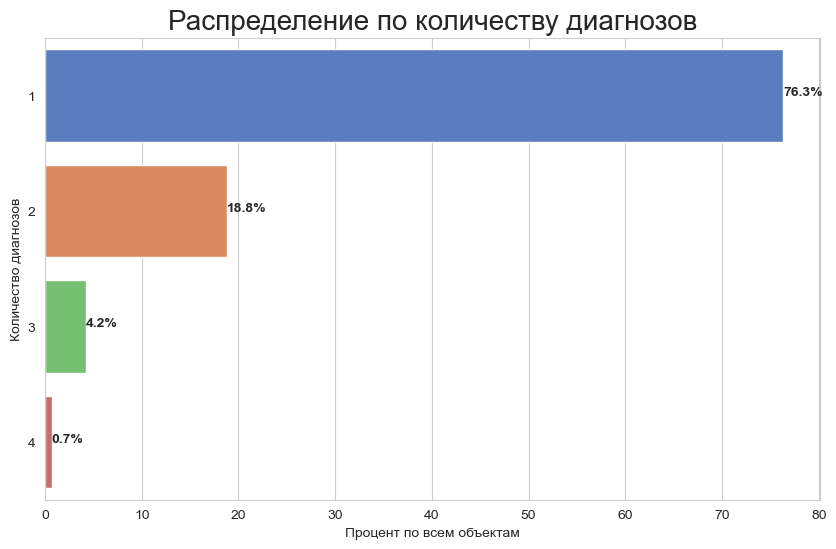

In [31]:
vc = df['scp_superclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Распределение по количеству диагнозов", fontsize=20)
ax.set_xlabel ("Процент по всем объектам")
ax.set_ylabel ("Количество диагнозов")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
plt.show()    

In [32]:
vc

scp_superclass_len
1    16101
2     3961
3      893
4      143
Name: count, dtype: int64

Значения классов:

NORM: Нормальная ЭКГ

MI: Инфаркт миокарда, инфаркт миокарда (ИМ), широко известный как сердечный приступ, возникает, когда поток крови уменьшается или прекращается в части сердца, вызывая повреждение сердечной мышцы.

STTC: Изменение ST/T. Изменения зубцов ST и T могут указывать на сердечную патологию или быть вариантом нормы. Таким образом, интерпретация результатов зависит от клинического контекста и наличия аналогичных результатов на предыдущих электрокардиограммах.

CD: Conduction Disturbance. Ваш сердечный ритм – это то, как бьется ваше сердце. Проводимость – это то, как электрические импульсы проходят через ваше сердце, заставляя его биться. Некоторые нарушения проводимости могут вызывать аритмии или нерегулярное сердцебиение.

HYP: Гипертрофия. Гипертрофическая кардиомиопатия (ГКМП) — заболевание, при котором сердечная мышца становится аномально толстой (гипертрофированной). Утолщенная сердечная мышца может затруднить перекачку крови сердцу.

Строим распределение подклассов диагнозов

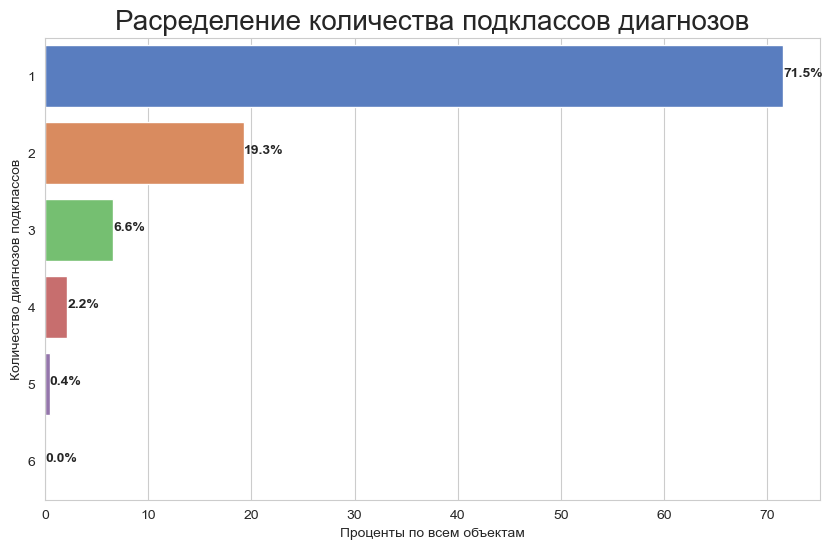

In [35]:

vc = df['scp_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Расределение количества подклассов диагнозов", fontsize=20)
ax.set_xlabel ("Проценты по всем объектам")
ax.set_ylabel ("Количество диагнозов подклассов")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
plt.show()     

Создаем ряда суперкласса, подкласса диагнозов.
Фомируем ряд имено новых колонок данных.

In [37]:
all_superclass = pd.Series(np.concatenate(df['scp_superclass'].values))
all_subclass = pd.Series(np.concatenate(df['scp_subclass'].values))
superclass_cols = all_superclass.unique()
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols])
meta_cols = ['age', 'nurse', 'site', 'device', 'sex', 'height', 'weight', 'heart_axis','validated_by_human',
             'pacemaker', 'electrodes_problems', 'burst_noise','static_noise','baseline_drift']

In [38]:
df

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1            15709  56.0    1     NaN    63.0      2     0   CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0   CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0   CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0   CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21832         7954  63.0    0     NaN     NaN      1     2  AT-60    3   
21833        17180  67.0    1     NaN     NaN      1     2  AT-60    3   
21835        19311  59.0    1     NaN     NaN      1     2  AT-60    3   
21836         8873  64.0    1     NaN     NaN      1     2  AT-60    3   
21837        11744  68.0    0     NaN     NaN      1     2  AT-60    3   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
...                     ...   
21832   2001-05-30 14:14:25   
21833   2001-05-31 09:14:35   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  ...  \
ecg_id                                                     ...   
1                  sinusrhythmus periphere niederspannung  ...   
2                     sinusbradykardie sonst normales ekg  ...   
3                              sinusrhythmus normales ekg  ...   
4                              sinusrhythmus normales ekg  ...   
5                              sinusrhythmus normales ekg  ...   
...                                                   ...  ...   
21832   sinusrhythmus linkstyp periphere niederspannun...  ...   
21833   ventrikulÄre extrasystole(n) sinustachykardie ...  ...   
21835   sinusrhythmus lagetyp normal t abnorm in anter...  ...   
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...  ...   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...  ...   

       electrodes_problems extra_beats pacemaker strat_fold  \
ecg_id                                                        
1                      NaN         NaN       NaN          3   
2                      NaN         NaN       NaN          2   
3                      NaN         NaN       NaN          5   
4                      NaN         NaN       NaN          3   
5                      NaN         NaN       NaN          4   
...                    ...         ...       ...        ...   
21832                  NaN         NaN       NaN          7   
21833                  NaN         1ES       NaN          7   
21835                  NaN         NaN       NaN          2   
21836                  NaN        SVES       NaN          8   
21837                  NaN         NaN       NaN          9   

                      filename_lr                filename_hr  scp_superclass  \
ecg_id                                                                         
1       records100/00000/00001_lr  records500/00000/00001_hr          [NORM]   
2       records100/00000/00002_lr  records500/00000/00002_hr          [NORM]   
3       records100/00000/00003_lr  records500/00000/00003_hr          [NORM]   
4       records100/00000/00004_lr  records500/00000/00004_hr          [NORM]   
5       records100/00000/00005_lr  records500/00000/00005_hr          [NORM]   
...                           ...                        ...             ...   
21832   records100/21000/21832_lr  records500/21000/21832_hr            [CD]   
21833   records100/21000/21833_lr  records500/21000/21833_hr          [STTC]   
21835   records100/21000/21835_lr  records500/21000/21835_hr          [STTC]   
21836   records100/21000/21836_lr  records500/21000/21836_hr          [NORM]   
21

Создаем новый датафрейм для анализа подклассов диагнозов

In [40]:
class SetterClasses():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['scp_superclass']:
            row[sc] = 1
        for sc in row['scp_subclass']:
            row[sc] = 1
            
        return row

def data_by_folds(folds, signal_data, y, update_cols, feature_cols):
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = signal_data[filt]
    y_selected = y[filt]
    print(filt)
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = SetterClasses(update_cols)    
    y_selected = y_selected.apply(cls_updt, axis=1)    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]

In [41]:
x_fold, y_fold = data_by_folds(np.arange(1, 11), x_raw_data, df, update_cols, meta_cols)

[ True  True  True ...  True  True  True]


In [42]:
display(df.head())

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1            15709  56.0    1     NaN    63.0      2     0  CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0  CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0  CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0  CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       electrodes_problems extra_beats pacemaker strat_fold  \
ecg_id                                                        
1                      NaN         NaN       NaN          3   
2                      NaN         NaN       NaN          2   
3                      NaN         NaN       NaN          5   
4                      NaN         NaN       NaN          3   
5                      NaN         NaN       NaN          4   

                      filename_lr                filename_hr  scp_superclass  \
ecg_id                                                                         
1       records100/00000/00001_lr  records500/00000/00001_hr          [NORM]   
2       records100/00000/00002_lr  records500/00000/00002_hr          [NORM]   
3       records100/00000/00003_lr  records500/00000/00003_hr          [NORM]   
4       records100/00000/00004_lr  records500/00000/00004_hr          [NORM]   
5       records100/00000/00005_lr  records500/00000/00005_hr          [NORM]   

        scp_superclass_len scp_subclass scp_subclass_len  
ecg_id                                                    
1                        1   [sub_NORM]                1  
2                        1   [sub_NORM]                1  
3                        1   [sub_NORM]                1  
4                        1   [sub_NORM]                1  
5                        1   [sub_NORM]                1  

[5 rows x 31 columns]

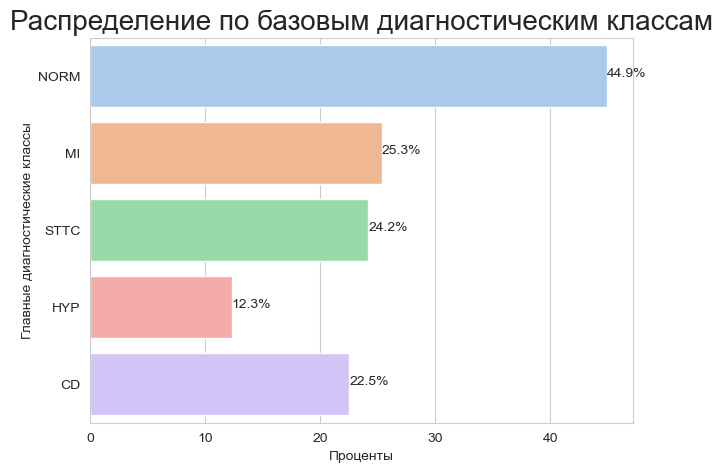

In [43]:
sub_col_sum = y_fold[superclass_cols].sum(axis=0)
bar,ax = plt.subplots(figsize=(7,5))
ax = sns.barplot(x=sub_col_sum.values/y_fold.shape[0]*100., y=sub_col_sum.index, ci=None, palette="pastel", orient='h')
ax.set_title("Распределение по базовым диагностическим классам", fontsize=20)
ax.set_ylabel ("Главные диагностические классы")
ax.set_xlabel ("Проценты")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width() )
plt.show()    

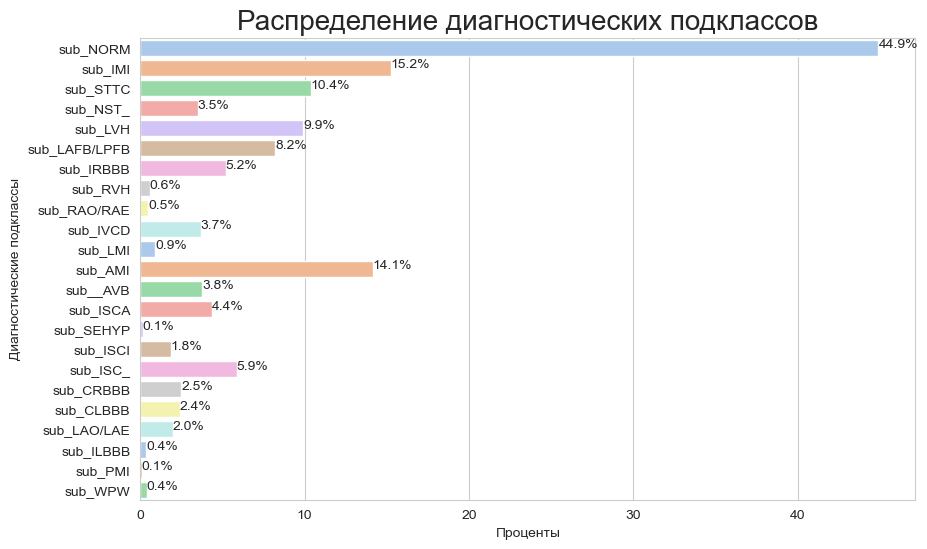

In [44]:
sub_col_sum = y_fold[subclass_cols].sum(axis=0)

bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = sub_col_sum.values / y_fold.shape[0] * 100., y=sub_col_sum.index, palette="pastel", orient='h')
ax.set_title("Распределение диагностических подклассов", fontsize=20)
ax.set_xlabel ("Проценты")
ax.set_ylabel ("Диагностические подклассы")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()    

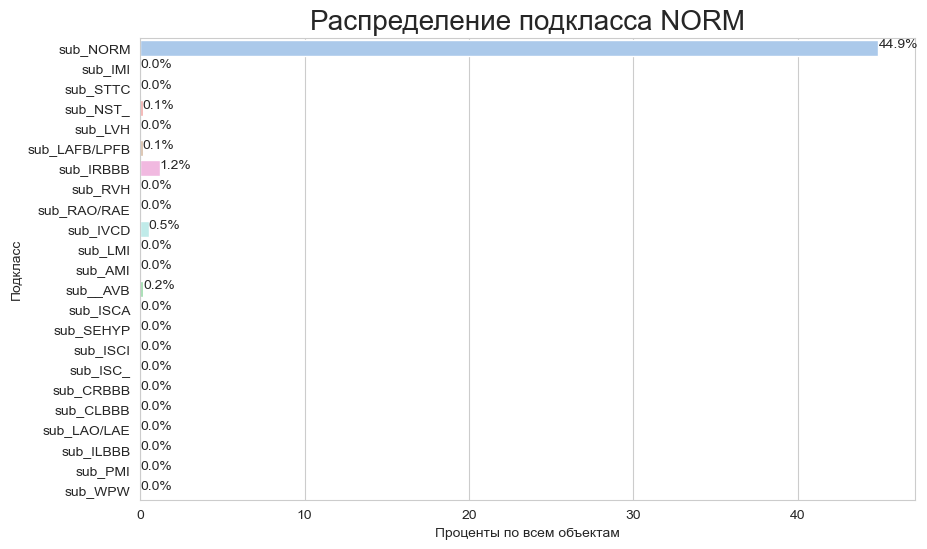

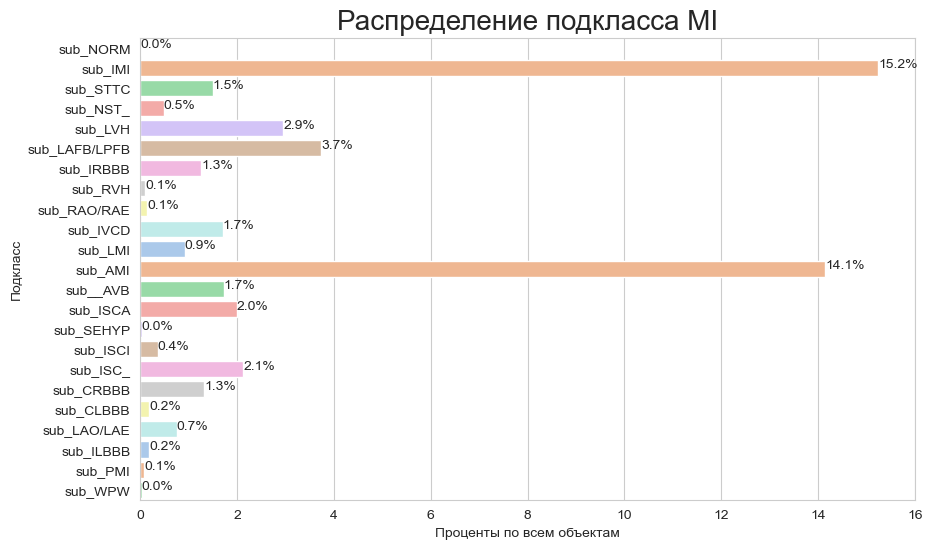

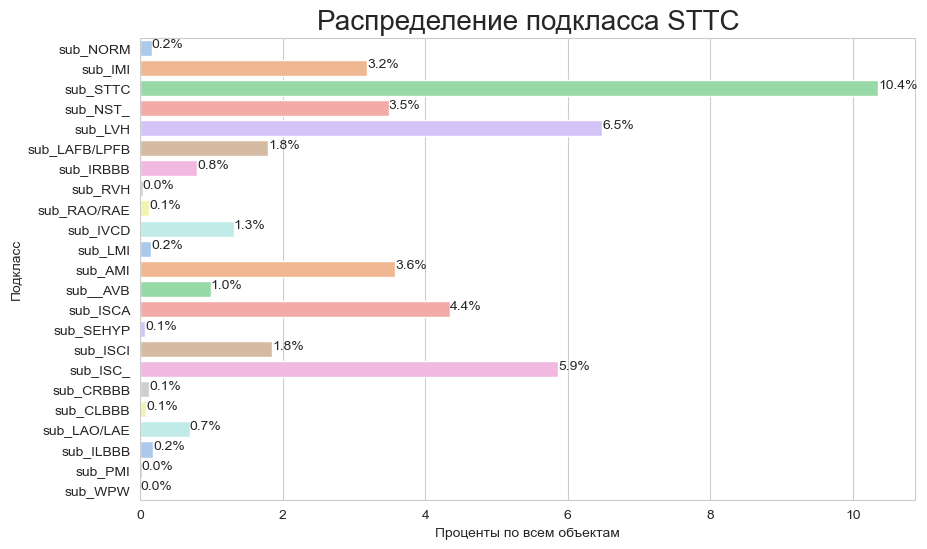

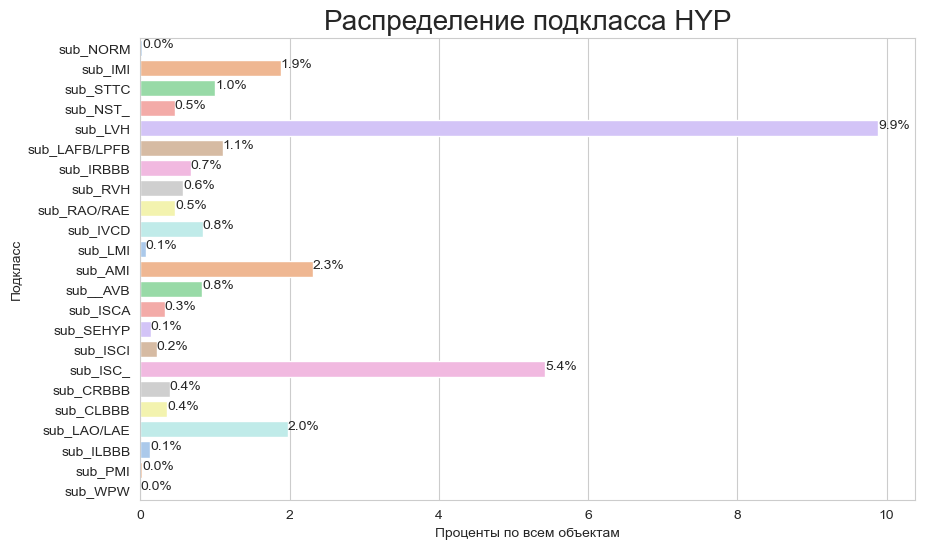

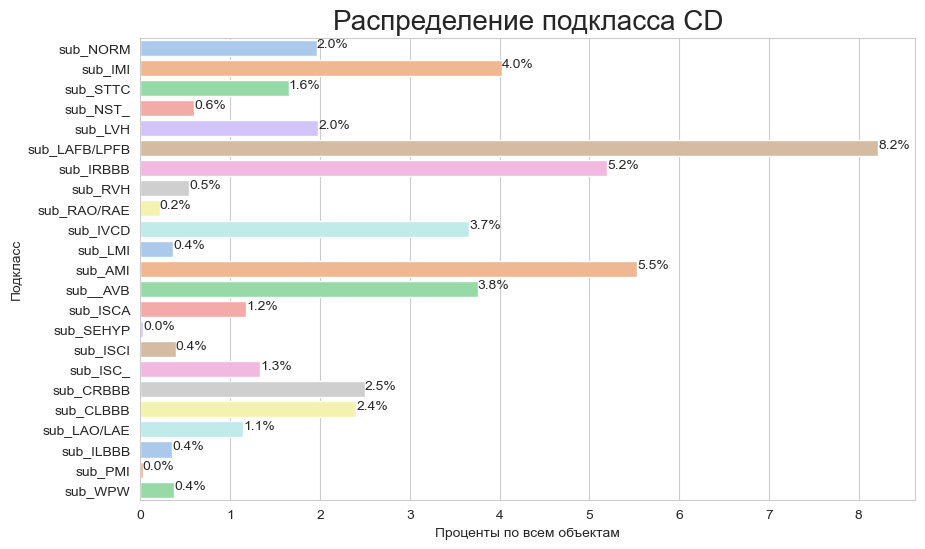

In [45]:
for superclass in superclass_cols:    
    sub_col_sum = y_fold.loc[y_fold[superclass] == 1][subclass_cols].sum(axis=0)    
    bar,ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(x=sub_col_sum.values / y_fold.shape[0] * 100., y= sub_col_sum.index, palette="pastel",orient='h')
    ax.set_title("Распределение подкласса {}".format(superclass), fontsize=20)
    ax.set_xlabel ("Проценты по всем объектам")
    ax.set_ylabel ("Подкласс")
    for rect in ax.patches:
        ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()        

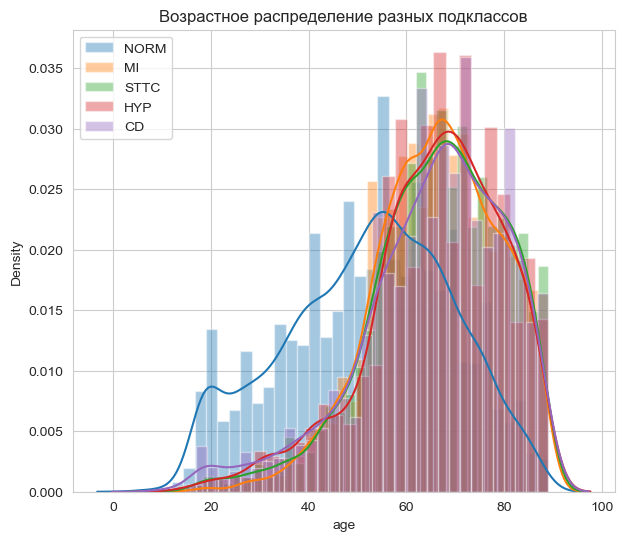

In [46]:
fig, ax = plt.subplots(figsize=(7,6))
plt.title('Возрастное распределение разных подклассов')
for superclass in superclass_cols:
    data = y_fold.loc[y_fold[superclass] == 1]['age']   
    sns.distplot(data, label=superclass)
plt.legend(loc='upper left')
plt.show()

Из диаграммы видно, что пик нормального состояния приходится примерно на 50 лет. После он начинает уменьшаться.
Пик категрии MI (инфаркт миакарда), HYP (Гипертония), CD (Нарушение сердечной проводимости), STTC (изменение ST сегмента) приходится на 65 лет.

Отобразим несколько примеров сырых данных полученных от аппарата ЭКГ

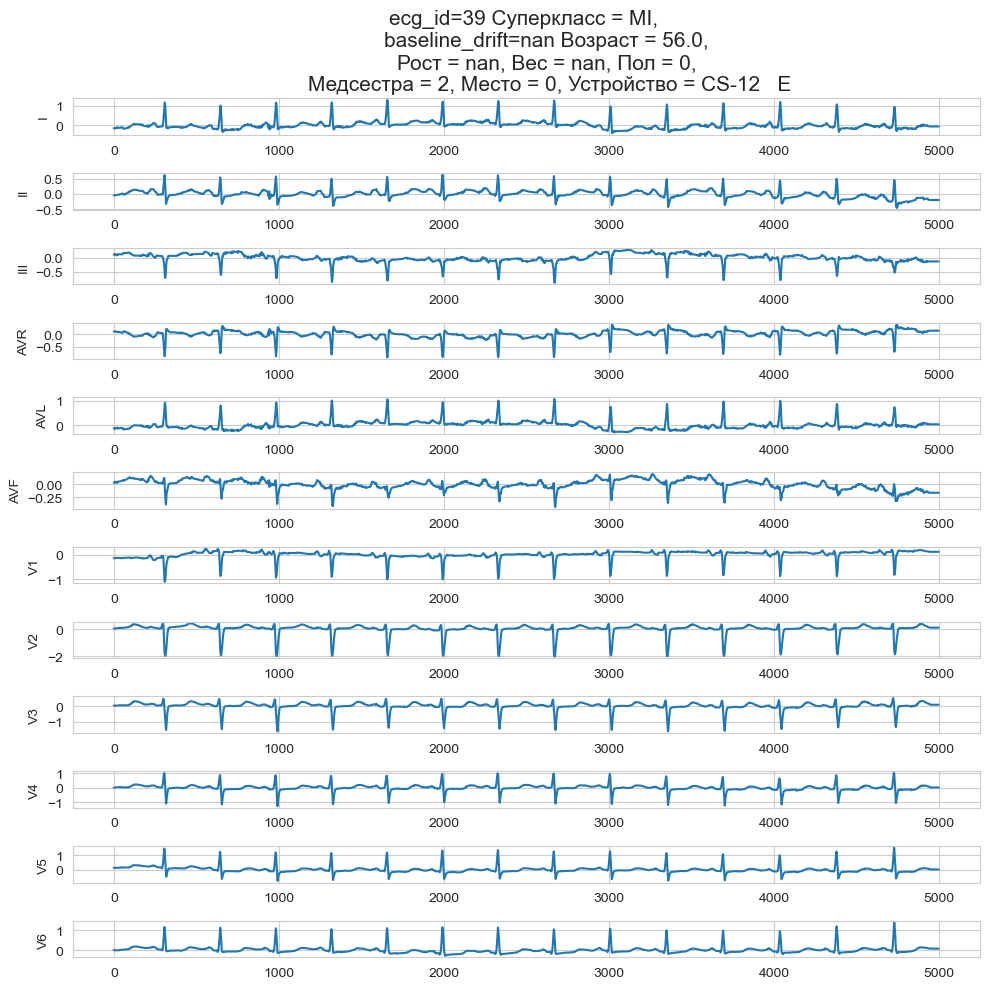

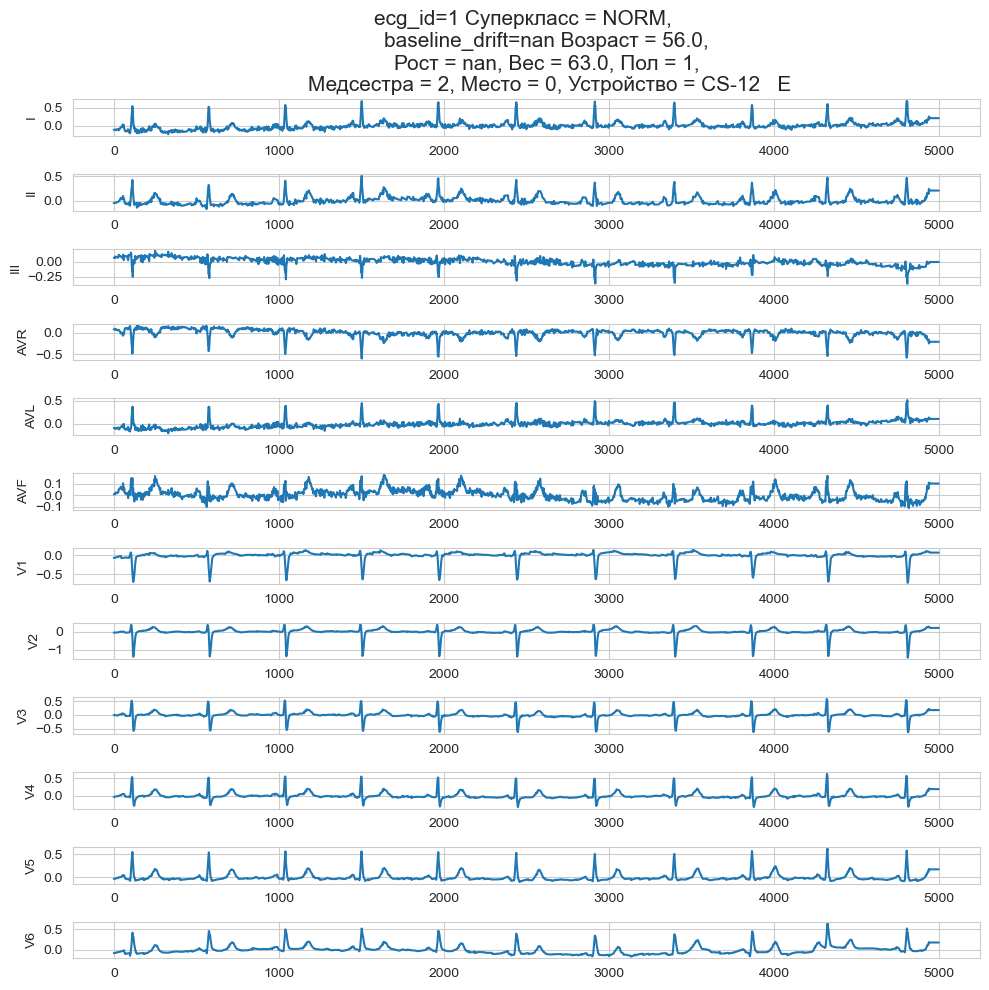

In [49]:
sample_num = 1

#superclass_cols
leads_caption = ['I','II','III', 'AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']
for superclass in ['MI','NORM']:
    filt =  (y_fold[superclass] == 1) & y_fold['baseline_drift'].isnull()
    y_selected = y_fold.loc[filt]
    x_selected = x_fold[filt]
    
    for i in range(sample_num):
        y_ = y_selected.iloc[i]
        index =  y_selected.index[i]
        x_ = x_selected[i]

        bar, axes = plt.subplots(x_.shape[1], 1, figsize=(10,10))
        title = f"""ecg_id={index} Суперкласс = {superclass}, 
        baseline_drift={y_['baseline_drift']} Возраст = {y_['age']}, 
        Рост = {y_['height']}, Вес = {y_['weight']}, Пол = {y_['sex']}, 
        Медсестра = {y_['nurse']}, Место = {y_['site']}, Устройство = {y_['device']}"""
        axes[0].set_title(title, fontsize=15)        
        for c in np.arange(x_.shape[1]):
            axes[c].set_ylabel(leads_caption[c])
            sns.lineplot(x=np.arange(x_.shape[0]), y=x_[:, c], ax=axes[c])        
        plt.tight_layout()
        plt.show()

In [50]:
import neurokit2 as nk
import numpy as np
import pandas as pd

In [51]:
!pip install neurokit2

In [52]:
def calc_rr(rr): 
  hr = 60000/rr
  diff_50_ms = 50
  diff_20_ms = 20
  results = {}
  results['mean_(ms)'] = np.mean(rr)
  results['STD RR/SDNN (ms)'] = np.std(rr)
  results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
  results['Mean HR (beats/min)'] = np.mean(hr)
  results['STD HR (beats/min)'] = np.std(hr)
  results['Min HR (beats/min)'] = np.min(hr)
  results['Max HR (beats/min)'] = np.max(hr)
  results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
  results['NN50'] = np.sum(np.abs(np.diff(rr)) > diff_50_ms)*1
  results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > diff_50_ms)*1) / len(rr)
  results['NN20'] = np.sum(np.abs(np.diff(rr)) > diff_20_ms)*1
  results['pNN20 (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > diff_20_ms)*1) / len(rr)
  return results

def interval_peaks_stat(waves, df_signal, time_size_ms=2):
   l = len(waves['ECG_R_Peaks'])
   rpeaks = waves['ECG_R_Peaks']
   aggr_set = []
    
   sl_pr_interval = [] 
   sl_pr_segment = []
   sl_QRS_complex = []
   sl_QT_interval = [] 
   sl_ST_segment = []

   m2_Q_P_diff = []
   m2_P_P_onset_diff = []
   m2_R_P_diff = []
   m2_S_P_diff = []
   m2_T_Q_diff = []
   m2_T_P_diff = []
   m2_T_S_diff = []
   m2_T_R_diff = []
   m2_T_offset_P_onset = [] 
   r_peak_amplitude = []
   t_peak_amplitude = []
   q_peak_amplitude = []
   s_peak_amplitude = []     
   p_peak_amplitude = []
    
   counter = 0
   for i, R_peak in enumerate(rpeaks):
       P_offset = waves['ECG_P_Offsets'][i]
       P_peak = waves['ECG_P_Peaks'][i]
       P_onset = waves['ECG_P_Onsets'][i]
       T_onset = waves['ECG_T_Onsets'][i]
       T_peak = waves['ECG_T_Peaks'][i]
       T_offset = waves['ECG_T_Offsets'][i]
       S_peak = waves['ECG_S_Peaks'][i]
       Q_peak = waves['ECG_Q_Peaks'][i]
       if np.isnan(P_offset) | np.isnan(P_onset) | np.isnan(T_onset)| np.isnan(R_peak) | np.isnan(T_offset) | np.isnan(S_peak) | np.isnan(Q_peak):
           continue
       if not (P_onset <= P_peak <= P_offset <= Q_peak <= R_peak <= S_peak <=T_onset <= T_peak <= T_offset):
           continue
       counter += 1    
       s_offset = (T_onset + S_peak)/2       
       P_len = (P_offset - P_onset)       
       q_onset = (P_offset + Q_peak)/2
       
       metric_PR_interval = (q_onset - P_onset)
       metric_PR_segment = q_onset - P_offset
       metric_QRS_complex = s_offset - q_onset
       metric_QT_interval = T_offset - q_onset
       metric_ST_segment = T_onset - s_offset

       # искуственные метрики. Надо проверить, что они положительно влияют на предсказание
       m2_Q_P_diff.append((Q_peak - P_peak)*time_size_ms)
       m2_P_P_onset_diff.append((P_peak - P_onset)*time_size_ms)
       m2_R_P_diff.append((R_peak - P_peak)*time_size_ms)
       m2_S_P_diff.append((S_peak - P_peak)*time_size_ms)
       m2_T_Q_diff.append((T_peak - Q_peak)*time_size_ms)
       m2_T_P_diff.append((T_peak - P_peak)*time_size_ms)
       m2_T_S_diff.append((T_peak - S_peak)*time_size_ms)
       m2_T_R_diff.append((T_peak - R_peak)*time_size_ms)
       m2_T_offset_P_onset.append((T_offset - P_onset)*time_size_ms)
       
       sl_pr_interval.append(metric_PR_interval*time_size_ms)
       sl_pr_segment.append(metric_PR_segment*time_size_ms)
       sl_QRS_complex.append(metric_QRS_complex*time_size_ms)
       sl_QT_interval.append(metric_QT_interval*time_size_ms)
       sl_ST_segment.append(metric_ST_segment*time_size_ms)

       r_peak_amplitude.append(df_signal['ECG_Clean'].iloc[R_peak])
       t_peak_amplitude.append(df_signal['ECG_Clean'].iloc[T_peak])
       q_peak_amplitude.append(df_signal['ECG_Clean'].iloc[Q_peak])
       s_peak_amplitude.append(df_signal['ECG_Clean'].iloc[S_peak])      
       p_peak_amplitude.append(df_signal['ECG_Clean'].iloc[P_peak])

    
   #'ECG_P_Peaks': [517, 983, 1449, 1909, 2383, 2858, 3329, 3812, 4271, nan],
   #'ECG_Q_Peaks': [559, 1021, 1484, 1948, 2414, 2896, 3366, 3852, 4306, nan],
   #'ECG_S_Peaks': [649, 1105, 1578, 2029, 2484, 3002, 3446, 3947, 4417, nan],
   #'ECG_T_Peaks': [718, 1179, 1641, 2107, 2578, 3058, 3536, 4010, 4465, nan],
   #'ECG_P_Onsets': [483, 961, 1384, 1889, 2302, 2819, 3252, 3735, 4236, nan],
   #'ECG_T_Offsets'
   aggr = {
       'R_peak_amplitude':np.mean(r_peak_amplitude),
       'T_peak_amplitude':np.mean(t_peak_amplitude),
       'Q_peak_amplitude':np.mean(q_peak_amplitude),
       'S_peak_amplitude':np.mean(s_peak_amplitude),
       'P_peak_amplitude':np.mean(p_peak_amplitude),
       
       'm2_Q_P_diff': np.mean(m2_Q_P_diff),
       'm2_P_P_onset_diff':np.mean(m2_P_P_onset_diff),
       'm2_R_P_diff': np.mean(m2_R_P_diff),
       'm2_S_P_diff': np.mean(m2_S_P_diff),
       'm2_T_Q_diff': np.mean(m2_T_Q_diff),
       'm2_T_P_diff': np.mean(m2_T_P_diff),
       'm2_T_S_diff':np.mean(m2_T_S_diff),
       'm2_T_R_diff':np.mean(m2_T_R_diff),
       'm2_T_offset_P_onset':np.mean(m2_T_offset_P_onset),
       'mean_PR_interval': np.mean(sl_pr_interval), 
       'mean_PR_segment': np.mean(sl_pr_segment),
       'mean_QRS_complex' :np.mean(sl_QRS_complex),
       'mean_QT_interval' :np.mean(sl_QT_interval),
       'mean_ST_segment' :np.mean(sl_ST_segment),       
       'std_PR_interval': np.std(sl_pr_interval), 
       'std_PR_segment': np.std(sl_pr_segment),
       'std_QRS_complex' :np.std(sl_QRS_complex),
       'std_QT_interval' :np.std(sl_QT_interval),
       'std_ST_segment' :np.std(sl_ST_segment),
       'number': counter,
       'total_r_peaks': len(rpeaks)
   }
   return aggr

In [81]:
def make_new_features(row, ecg_df, srate=500, processed_leads = ['I'], show=False):
    
    SOURCE = 'ECG_Clean'

    exception_counter = 0
    union_result = {}
    ecg_Rate = 0
    for lean_code in processed_leads:
        processed_signal, norm_info = nk.ecg_process(ecg_df[lean_code], sampling_rate=srate)
        df_R_peaks, map_R_peaks = nk.ecg_peaks(processed_signal['ECG_Clean'], sampling_rate=srate)
        signal_peak, waves_peak = nk.ecg_delineate(processed_signal[SOURCE], map_R_peaks, sampling_rate=srate, 
                                                       method="peaks", show_type='all', show=False)
        p_signal_dwt, p_waves_dwt = nk.ecg_delineate(processed_signal[SOURCE], map_R_peaks, sampling_rate=srate, 
                                         method="dwt", show=False, show_type='bounds_P')
        t_signal_dwt, t_waves_dwt = nk.ecg_delineate(processed_signal[SOURCE], map_R_peaks, sampling_rate=srate, 
                                         method="dwt", show=False, show_type='bounds_T')
        waves = {}
        ls = ['ECG_P_Onsets','ECG_P_Peaks','ECG_Q_Peaks','ECG_S_Peaks','ECG_T_Peaks','ECG_T_Offsets']
        for key in ls:
            waves[key] = waves_peak[key]
        waves['ECG_P_Offsets'] =p_waves_dwt['ECG_P_Offsets']
        waves['ECG_R_Peaks']= map_R_peaks['ECG_R_Peaks']
        waves['ECG_T_Onsets']=t_waves_dwt['ECG_T_Onsets']

        df_waves = pd.DataFrame.from_dict(waves)
        #print(f'index={index} {row['patient_id']} {row['age']} {row['scp_superclass']}')

        discret_time = 2
        rr = np.diff(waves['ECG_R_Peaks']) * discret_time
        rr_stats = calc_rr(rr)
        ecg_Rate = processed_signal['ECG_Rate'].mean()
        interval_stat = interval_peaks_stat(waves, processed_signal, discret_time)
        #display(interval_stat)
        # добавляем префикс к каждому ключу словаря
        interval_stat = {lean_code + '_interval_' + str(key): val for key, val in interval_stat.items()}
        rr_stats = {lean_code + '_stat_' + str(key): val for key, val in rr_stats.items()}
        union_result = {**union_result, **interval_stat}
        union_result = {**union_result, **rr_stats}
        if show:
            limit=2000
            limit_peaks=5
            plt.figure(figsize=(15,3))
            ymax=processed_signal['ECG_Clean'].values.max()
            ymin=processed_signal['ECG_Clean'].values.min()
            plt.plot(processed_signal['ECG_Clean'].values[:limit], label="ecg", color="Red")                         
            plt.vlines(x = waves_peak['ECG_P_Onsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Blue', label='P_begin', linestyle='dotted')
            plt.vlines(x = waves_peak['ECG_P_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Blue', label='P_Peaks', linestyle='solid')
            plt.vlines(x = p_waves_dwt['ECG_P_Offsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Blue', label='P_end', linestyle='dashdot')
            plt.vlines(x = waves_peak['ECG_Q_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Black', label='Q_Peaks', linestyle='solid')
            plt.vlines(x = map_R_peaks['ECG_R_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Red', label='R_Peaks', linestyle='solid')
            plt.vlines(x = waves_peak['ECG_S_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Yellow', label='S_Peaks', linestyle='solid')
            plt.vlines(x = t_waves_dwt['ECG_T_Onsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Green', label='T_Onsets', linestyle='dotted')
            plt.vlines(x = waves_peak['ECG_T_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Green', label='T_Peaks', linestyle='solid')
            plt.vlines(x = waves_peak['ECG_T_Offsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Green', label='T_end', linestyle='dashdot')
                 
            #plt.vlines(x = norm_info['ECG_T_Onsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Aqua', label='T_Onsets', linestyle='dotted')
            #plt.vlines(x = norm_info['ECG_T_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Aqua', label='T_Peaks', linestyle='solid')
            #plt.vlines(x = norm_info['ECG_T_Offsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Aqua', label='T_end', linestyle='dashdot')

            plt.legend()
            plt.show()
        #try:
            #hrv_indices = nk.hrv(df_R_peaks, sampling_rate=500)
            #display(hrv_indices)
        #except:
        #    exception_counter+=1
            

        # Хорошо определяются только P_onset, P_peak, Q_peak, R_peak, S_peak, T_peak, T_offset
    union_result['ECG_Rate_mean'] = ecg_Rate
    return union_result

In [87]:
# Для минимального анализа нужно проверять следующие отведения.
# Левые - I, aVL, V5 и V6 отведения
# Правые- III, aVF, VI и V2
df_reseted = df.reset_index()
leads_columns = ['I','II','III', 'AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']
processed_leads = ['V5', 'V2']
assert df_reseted.shape[0] == x_raw_data.shape[0] 

new_df_features = pd.DataFrame()
pd.set_option('display.max_columns', None)
exception_counter = 0
for index in np.arange(0,df_reseted.shape[0],1):
#for index in np.arange(0,3,1):
  print(f"index={index} errors={exception_counter}")
  sample_meta_data = df_reseted.loc[index].to_dict()
  ecg_df = pd.DataFrame(data=x_raw_data[index], columns=leads_columns)
  try:  
    features = make_new_features(sample_meta_data, ecg_df, processed_leads = processed_leads, srate=500, show=False)
    patient_features = {**sample_meta_data, **features}
    if new_df_features.shape[0] == 0:
      new_df_features = pd.DataFrame([patient_features], columns=patient_features.keys())
    else:    
      row_feature  = pd.DataFrame([patient_features], columns=patient_features.keys())  
      new_df_features = pd.concat([new_df_features, row_feature])
  except:
    exception_counter +=1  
    print(f"fatal on {sample_meta_data}")

new_df_features.to_csv('v5_v2_ecg_extracted_features.csv', index=False)
display(new_df_features)

index=0 errors=0
index=1 errors=0
index=2 errors=0
index=3 errors=0
index=4 errors=0
fatal on {'ecg_id': 5, 'patient_id': 17448, 'age': 19.0, 'sex': 1, 'height': nan, 'weight': 70.0, 'nurse': 2, 'site': 0, 'device': 'CS-12   E', 'recording_date': '1984-11-17 10:43:15', 'report': 'sinusrhythmus normales ekg', 'scp_codes': {'NORM': 100.0, 'SR': 0.0}, 'heart_axis': nan, 'infarction_stadium1': nan, 'infarction_stadium2': nan, 'validated_by': None, 'second_opinion': False, 'initial_autogenerated_report': False, 'validated_by_human': True, 'baseline_drift': ' , III,AVR,AVF', 'static_noise': nan, 'burst_noise': nan, 'electrodes_problems': nan, 'extra_beats': nan, 'pacemaker': nan, 'strat_fold': 4, 'filename_lr': 'records100/00000/00005_lr', 'filename_hr': 'records500/00000/00005_hr', 'scp_superclass': ['NORM'], 'scp_superclass_len': 1, 'scp_subclass': ['sub_NORM'], 'scp_subclass_len': 1}
index=5 errors=1
index=6 errors=1
index=7 errors=1
index=8 errors=1
index=9 errors=1
index=10 errors=1
ind

ecg_id  patient_id   age  sex  height  weight nurse site      device  \
0        1       15709  56.0    1     NaN    63.0     2    0   CS-12   E   
0        2       13243  19.0    0     NaN    70.0     2    0   CS-12   E   
0        3       20372  37.0    1     NaN    69.0     2    0   CS-12   E   
0        4       17014  24.0    0     NaN    82.0     2    0   CS-12   E   
0        6       19005  18.0    1     NaN    58.0     2    0   CS-12   E   
..     ...         ...   ...  ...     ...     ...   ...  ...         ...   
0    21832        7954  63.0    0     NaN     NaN     1    2  AT-60    3   
0    21833       17180  67.0    1     NaN     NaN     1    2  AT-60    3   
0    21835       19311  59.0    1     NaN     NaN     1    2  AT-60    3   
0    21836        8873  64.0    1     NaN     NaN     1    2  AT-60    3   
0    21837       11744  68.0    0     NaN     NaN     1    2  AT-60    3   

         recording_date                                             report  \
0   1984-11-09 09:17:34             sinusrhythmus periphere niederspannung   
0   1984-11-14 12:55:37                sinusbradykardie sonst normales ekg   
0   1984-11-15 12:49:10                         sinusrhythmus normales ekg   
0   1984-11-15 13:44:57                         sinusrhythmus normales ekg   
0   1984-11-28 13:32:13                         sinusrhythmus normales ekg   
..                  ...                                                ...   
0   2001-05-30 14:14:25  sinusrhythmus linkstyp periphere niederspannun...   
0   2001-05-31 09:14:35  ventrikulÄre extrasystole(n) sinustachykardie ...   
0   2001-06-08 10:30:27  sinusrhythmus lagetyp normal t abnorm in anter...   
0   2001-06-09 18:21:49  supraventrikulÄre extrasystole(n) sinusrhythmu...   
0   2001-06-11 16:43:01  sinusrhythmus p-sinistrocardiale lagetyp norma...   

                                            scp_codes heart_axis  \
0            {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN   
0                        {'NORM': 80.0, 'SBRAD': 0.0}        NaN   
0                          {'NORM': 100.0, 'SR': 0.0}        NaN   
0                          {'NORM': 100.0, 'SR': 0.0}        NaN   
0                          {'NORM': 100.0, 'SR': 0.0}        NaN   
..                                                ...        ...   
0           {'LAFB': 100.0, 'IVCD': 100.0, 'SR': 0.0}        LAD   
0   {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...        LAD   
0                          {'ISCAS': 50.0, 'SR': 0.0}        MID   
0                          {'NORM': 100.0, 'SR': 0.0}        LAD   
0                          {'NORM': 100.0, 'SR': 0.0}        MID   

   infarction_stadium1 infarction_stadium2 validated_by  second_opinion  \
0                  NaN                 NaN         None           False   
0                  NaN                 NaN         None           False   
0                  NaN                 NaN         None           False   
0                  NaN                 NaN         None           False   
0                  NaN                 NaN         None           False   
..                 ...                 ...          ...             ...   
0                  NaN                 NaN            1           False   
0                  NaN                 NaN            1           False   
0                  NaN                 NaN            1            True   
0                  NaN                 NaN            1           False   
0                  NaN                 NaN            1           False   

    initial_autogenerated_report  validated_by_human baseline_drift  \
0                          False                True            NaN   
0                          False                True            NaN   
0                          False                True            NaN   
0                          False                True   , II,III,AVF   
0                          False                True           , V1   
..        

In [ ]:
df_reseted.tail()

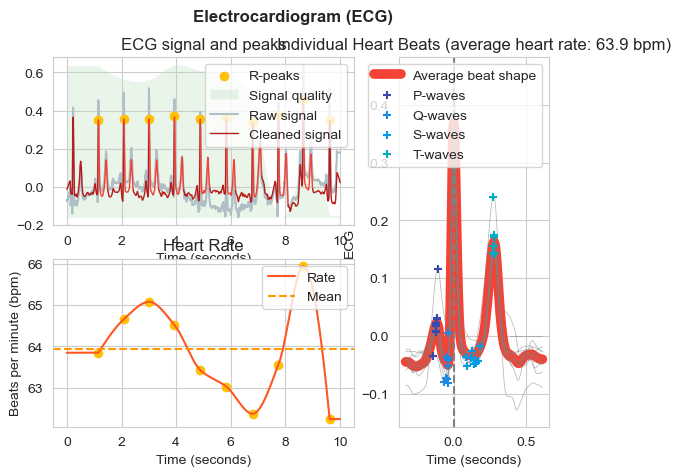

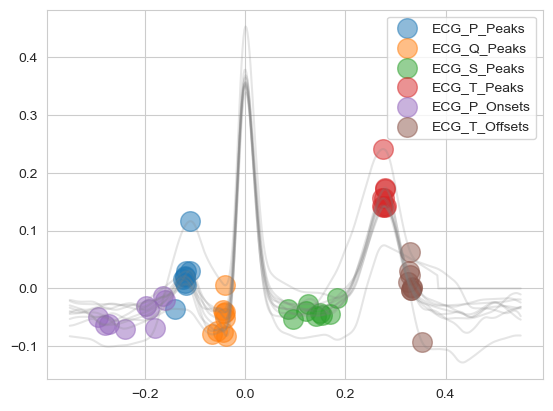

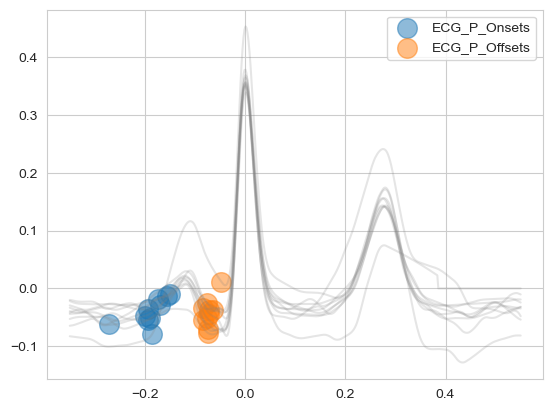

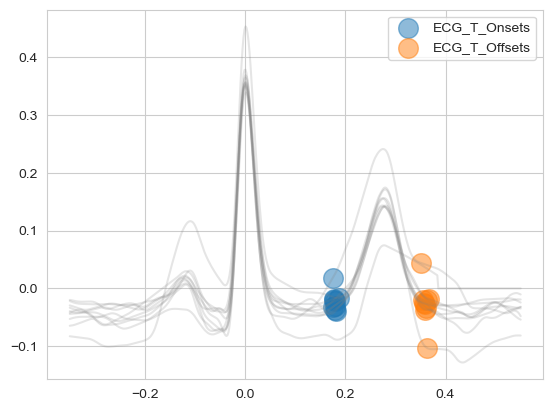

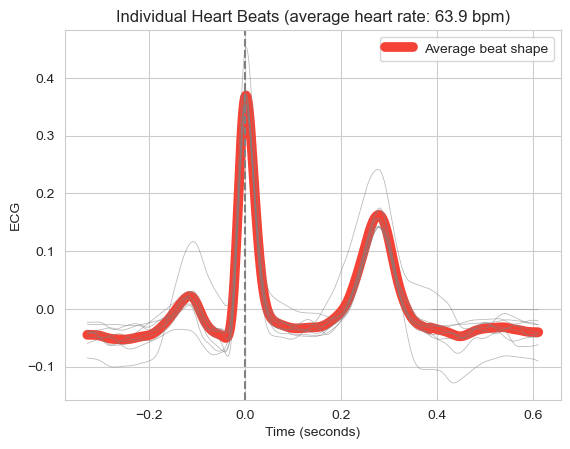

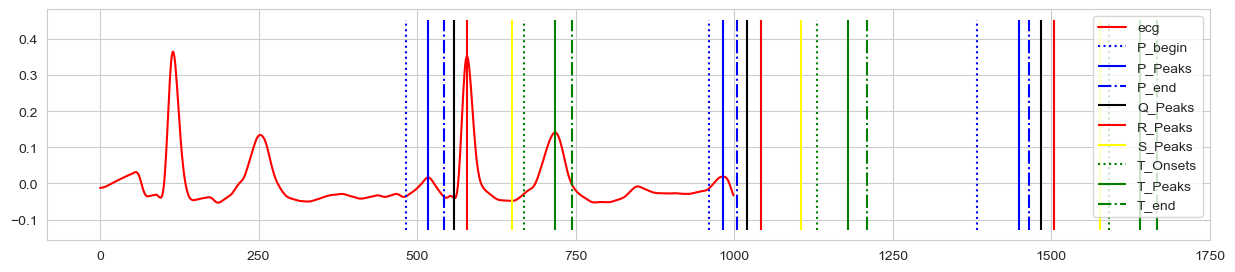

In [263]:
import neurokit2 as nk
import matplotlib as mpl
# Default processing pipeline
def make_analiz(ecg_df, lead='V6'):
  signals, norm_info = nk.ecg_process(ecg_df[lead], sampling_rate=500)
# Visualize
  nk.ecg_plot(signals, norm_info)
  df_rpeaks, map_rpeaks = nk.ecg_peaks(signals, sampling_rate=500)
  plt.show()

  source = 'ECG_Clean'
  sel_signal = signals[source]
  signal_peak, waves_peak = nk.ecg_delineate(sel_signal, map_rpeaks, sampling_rate=500, method="peaks", show_type='all',show=True)
  p_signal_dwt, p_waves_dwt = nk.ecg_delineate(sel_signal, 
                                         map_rpeaks, 
                                         sampling_rate=500, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='bounds_P')
  t_signal_dwt, t_waves_dwt = nk.ecg_delineate(sel_signal, 
                                         map_rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='bounds_T')
  epochs = nk.ecg_segment(sel_signal, rpeaks=None, sampling_rate=500, show=True)
  plt.show()
  

  plt.figure(figsize=(15,3))
  ymax=signals['ECG_Clean'].values.max()
  ymin=signals['ECG_Clean'].values.min()
  limit = 1000
  limit_peaks = 3
  plt.plot(signals['ECG_Clean'].values[:limit], label="ecg", color="Red")
  #plt.plot(signals['ECG_Raw'].values[:limit], label="ecg", color="Gray")
  plt.vlines(x = waves_peak['ECG_P_Onsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Blue', label='P_begin', linestyle='dotted')
  plt.vlines(x = waves_peak['ECG_P_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Blue', label='P_Peaks', linestyle='solid')
  plt.vlines(x = p_waves_dwt['ECG_P_Offsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Blue', label='P_end', linestyle='dashdot')
  plt.vlines(x = waves_peak['ECG_Q_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Black', label='Q_Peaks', linestyle='solid')
  plt.vlines(x = map_rpeaks['ECG_R_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Red', label='R_Peaks', linestyle='solid')
  plt.vlines(x = waves_peak['ECG_S_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Yellow', label='S_Peaks', linestyle='solid')

# ECG_T_Onsets определяется плохо.
# Хорошо определяются только P_onset, P_peak, Q_peak, R_peak, S_peak, T_peak, T_offset
  plt.vlines(x = t_waves_dwt['ECG_T_Onsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Green', label='T_Onsets', linestyle='dotted')
  plt.vlines(x = waves_peak['ECG_T_Peaks'][:limit_peaks], ymin = ymin, ymax=ymax, color='Green', label='T_Peaks', linestyle='solid')
  plt.vlines(x = waves_peak['ECG_T_Offsets'][:limit_peaks], ymin = ymin, ymax=ymax, color='Green', label='T_end', linestyle='dashdot')

  plt.legend()
  plt.show()  
  return signals, df_rpeaks, map_rpeaks, waves_peak, p_waves_dwt, t_waves_dwt, epochs

norm_processed_signal, norm_df_rpeaks, norm_map_rpeaks, norm_waves_peak, norm_p_waves_dwt, norm_t_waves_dwt, norm_epochs = make_analiz(ecg_df=ecg_df_norm, lead='V6')

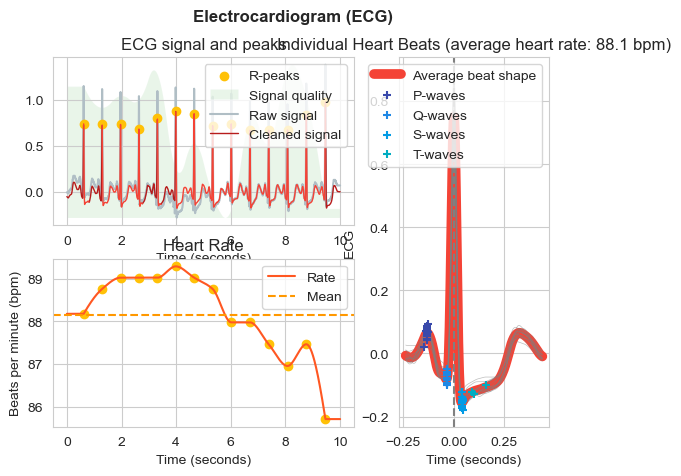

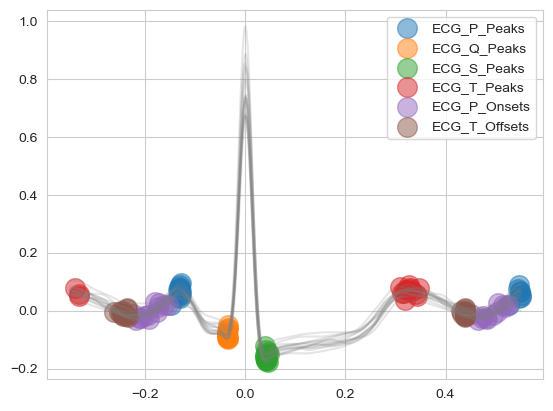

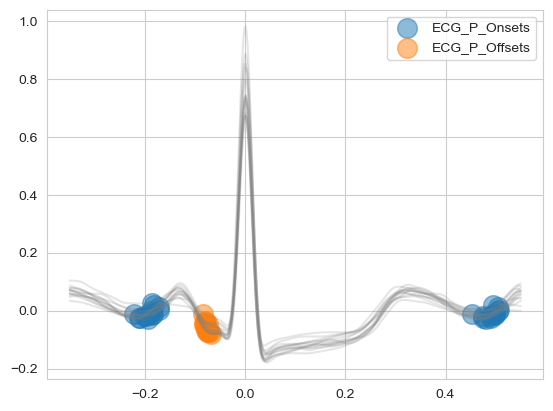

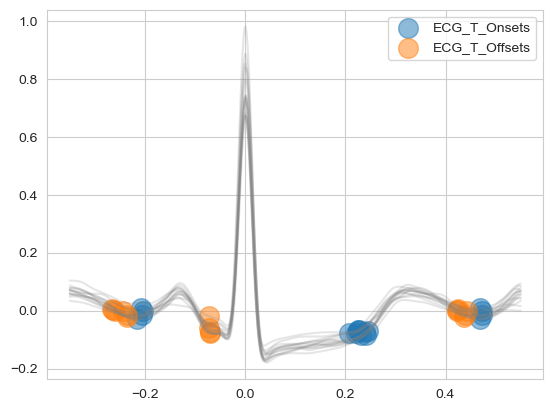

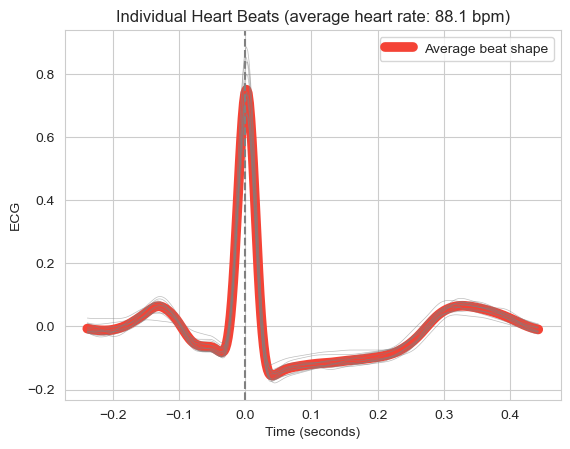

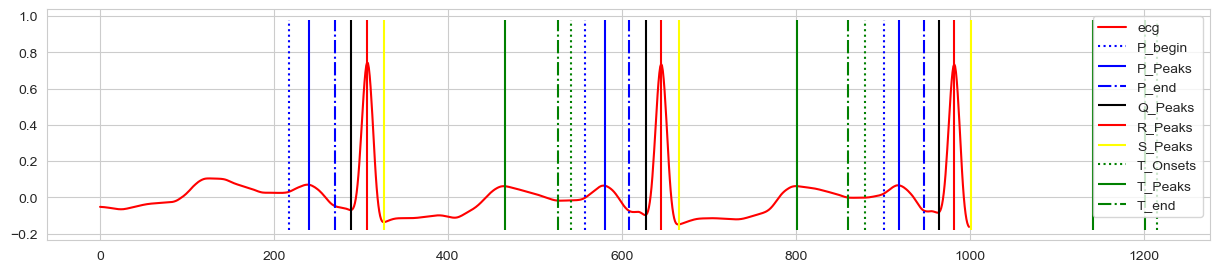

In [379]:
mi_processed_signal, mi_df_rpeaks, mi_map_rpeaks, mi_waves_peak, mi_p_waves_dwt, mi_t_waves_dwt, mi_epochs = make_analiz(ecg_df=ecg_df_mi, lead='V6')

In [131]:
for key in mi_waves_peak.keys():
    print(key + str(mi_waves_peak[key]) + str(len(mi_waves_peak[key])))

print("-------------")
for key in mi_t_waves_dwt.keys():
    print(key + str(mi_t_waves_dwt[key]) + str(len(mi_t_waves_dwt[key])))
display(mi_epochs)    

ECG_P_Peaks[240, 580, 918, 1253, 1591, 1918, 2264, 2603, 2944, 3282, 3626, 3972, 4315, nan]14
ECG_Q_Peaks[289, 628, 964, 1301, 1639, 1974, 2311, 2650, 2991, 3332, 3675, 4019, 4362, nan]14
ECG_S_Peaks[327, 666, 1001, 1338, 1679, 2014, 2351, 2687, 3027, 3369, 3711, 4057, 4401, nan]14
ECG_T_Peaks[465, 801, 1141, 1480, 1826, 2163, 2483, 2826, 3171, 3512, 3856, 4210, 4546, nan]14
ECG_P_Onsets[217, 557, 901, 1233, 1555, 1896, 2217, 2590, 2902, 3240, 3588, 3950, 4283, nan]14
ECG_T_Offsets[526, 860, 1201, 1538, 1875, 2208, 2548, 2886, 3227, 3568, 3911, 4256, 4599, nan]14
-------------
ECG_P_Onsets[548, 886, 1220, 1558, 1775, 2112, 2435, 2905, 3250, 3592, 3937, 4284, 4495]13
ECG_P_Peaks[579, 917, 1252, 1590, 1825, 2162, 2482, 2943, 3281, 3625, 3971, 4314, 4545]13
ECG_P_Offsets[603, 941, 1276, 1612, 1867, 2202, nan, 2965, 3306, 3648, 3994, 4338, nan]13
ECG_Q_Peaks[289, 628, 964, 1301, 1639, 1974, 2311, 2650, 2991, 3332, 3675, 4019, 4362, nan]14
ECG_R_Onsets[nan, 616, 932, nan, 1626, 1961, 2297, 

{'1':              Signal  Index Label
 -0.238232  0.026697    187     1
 -0.236231  0.026187    188     1
 -0.234229  0.025869    189     1
 -0.232227  0.025651    190     1
 -0.230225  0.025534    191     1
 ...             ...    ...   ...
  0.434424 -0.015916    523     1
  0.436426 -0.016694    524     1
  0.438428 -0.017281    525     1
  0.440430 -0.017719    526     1
  0.442432 -0.018006    527     1
 
 [341 rows x 3 columns],
 '2':              Signal  Index Label
 -0.238232 -0.017281    525     2
 -0.236231 -0.017719    526     2
 -0.234229 -0.018006    527     2
 -0.232227 -0.018172    528     2
 -0.230225 -0.018239    529     2
 ...             ...    ...   ...
  0.434424 -0.001543    861     2
  0.436426 -0.001866    862     2
  0.438428 -0.002078    863     2
  0.440430 -0.002191    864     2
  0.442432 -0.002215    865     2
 
 [341 rows x 3 columns],
 '3':              Signal  Index Label
 -0.238232 -0.001866    862     3
 -0.236231 -0.002078    863     3
 -0.234229 -0

In [285]:
display(mi_map_rpeaks)
discret_time = 2
rr = np.diff(mi_map_rpeaks['ECG_R_Peaks']) * discret_time # 2 миллисекунды - расстояние между замерами
tt_diff = np.diff(mi_t_waves_dwt['ECG_T_Peaks']) * discret_time
tc=tt_diff[~np.isnan(tt_diff)]
print(mi_t_waves_dwt['ECG_T_Peaks'])
print(tc)
def r_timedomain(rr): 
  hr = 60000/rr
  diff_30_ms = 50
  results = {}
  results['mean_(ms)'] = np.mean(rr)
  results['STD RR/SDNN (ms)'] = np.std(rr)
  results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
  results['Mean HR (beats/min)'] = np.mean(hr)
  results['STD HR (beats/min)'] = np.std(hr)
  results['Min HR (beats/min)'] = np.min(hr)
  results['Max HR (beats/min)'] = np.max(hr)
  results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
  results['NN50'] = np.sum(np.abs(np.diff(rr)) > diff_30_ms)*1
  results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > diff_30_ms)*1) / len(rr)
  return results
r_stat=r_timedomain(rr) 
t_stat=r_timedomain(tc)
print(r_stat)
print(t_stat)
print(mi_waves_peak['ECG_T_Peaks'])

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 307,  645,  982, 1319, 1656, 1992, 2329, 2667, 3008, 3349, 3692,
        4037, 4380, 4730]),
 'sampling_rate': 500}

[579, 917, 1252, 1479, 1825, 2162, 2482, 2943, 3170, 3511, 3855, 4209, 4545]
[676 670 454 692 674 640 922 454 682 688 708 672]
{'mean_(ms)': 680.4615384615385, 'STD RR/SDNN (ms)': 7.928676139523154, "Mean HR (Kubios' style) (beats/min)": 88.17544652950487, 'Mean HR (beats/min)': 88.18727642872776, 'STD HR (beats/min)': 1.015355030393566, 'Min HR (beats/min)': 85.71428571428571, 'Max HR (beats/min)': 89.28571428571429, 'RMSSD (ms)': 4.96655480858378, 'NN50': 0, 'pNN50 (%)': 0.0}
{'mean_(ms)': 661.0, 'STD RR/SDNN (ms)': 115.17956994768358, "Mean HR (Kubios' style) (beats/min)": 90.77155824508321, 'Mean HR (beats/min)': 93.8663358766169, 'STD HR (beats/min)': 18.403219233664025, 'Min HR (beats/min)': 65.0759219088937, 'Max HR (beats/min)': 132.15859030837004, 'RMSSD (ms)': 203.8448607954767, 'NN50': 5, 'pNN50 (%)': 41.666666666666664}
[465, 801, 1141, 1480, 1826, 2163, 2483, 2826, 3171, 3512, 3856, 4210, 4546, nan]


In [275]:
intr = nk.ecg_intervalrelated(mi_processed_signal,sampling_rate=500)
dictionary=intr.iloc[0].to_dict()
display(dictionary)

{'ECG_Rate_Mean': 88.1491954233835,
 'HRV_MeanNN': array([[680.46153846]]),
 'HRV_SDNN': array([[8.25242777]]),
 'HRV_SDANN1': array([[nan]]),
 'HRV_SDNNI1': array([[nan]]),
 'HRV_SDANN2': array([[nan]]),
 'HRV_SDNNI2': array([[nan]]),
 'HRV_SDANN5': array([[nan]]),
 'HRV_SDNNI5': array([[nan]]),
 'HRV_RMSSD': array([[4.96655481]]),
 'HRV_SDSD': array([[4.7482054]]),
 'HRV_CVNN': array([[0.01212769]]),
 'HRV_CVSD': array([[0.0072988]]),
 'HRV_MedianNN': array([[676.]]),
 'HRV_MadNN': array([[5.9304]]),
 'HRV_MCVNN': array([[0.00877278]]),
 'HRV_IQRNN': array([[12.]]),
 'HRV_SDRMSSD': array([[1.66160006]]),
 'HRV_Prc20NN': array([[674.]]),
 'HRV_Prc80NN': array([[686.]]),
 'HRV_pNN50': array([[0.]]),
 'HRV_pNN20': array([[0.]]),
 'HRV_MinNN': array([[672.]]),
 'HRV_MaxNN': array([[700.]]),
 'HRV_HTI': array([[1.85714286]]),
 'HRV_TINN': array([[0.]]),
 'HRV_ULF': array([[nan]]),
 'HRV_VLF': array([[nan]]),
 'HRV_LF': array([[nan]]),
 'HRV_HF': array([[nan]]),
 'HRV_VHF': array([[nan]]),

In [381]:
hrv_indices = nk.hrv(mi_df_rpeaks, sampling_rate=500, )

plt.show()
dictionary = hrv_indices.iloc[0].to_dict()
display(dictionary)
display(hrv_indices)

{'HRV_MeanNN': 680.4615384615385,
 'HRV_SDNN': 8.252427770211872,
 'HRV_SDANN1': nan,
 'HRV_SDNNI1': nan,
 'HRV_SDANN2': nan,
 'HRV_SDNNI2': nan,
 'HRV_SDANN5': nan,
 'HRV_SDNNI5': nan,
 'HRV_RMSSD': 4.96655480858378,
 'HRV_SDSD': 4.748205402618399,
 'HRV_CVNN': 0.012127691726515299,
 'HRV_CVSD': 0.007298803132668906,
 'HRV_MedianNN': 676.0,
 'HRV_MadNN': 5.9304,
 'HRV_MCVNN': 0.008772781065088758,
 'HRV_IQRNN': 12.0,
 'HRV_SDRMSSD': 1.66160006045822,
 'HRV_Prc20NN': 674.0,
 'HRV_Prc80NN': 686.0,
 'HRV_pNN50': 0.0,
 'HRV_pNN20': 0.0,
 'HRV_MinNN': 672.0,
 'HRV_MaxNN': 700.0,
 'HRV_HTI': 1.8571428571428572,
 'HRV_TINN': 0.0,
 'HRV_ULF': nan,
 'HRV_VLF': nan,
 'HRV_LF': nan,
 'HRV_HF': nan,
 'HRV_VHF': nan,
 'HRV_TP': 0.0,
 'HRV_LFHF': nan,
 'HRV_LFn': nan,
 'HRV_HFn': nan,
 'HRV_LnHF': nan,
 'HRV_SD1': 3.3574882386580707,
 'HRV_SD2': 9.887243081748089,
 'HRV_SD1SD2': 0.3395777984720548,
 'HRV_S': 104.28925961964998,
 'HRV_CSI': 2.944833273846358,
 'HRV_CVI': 2.7252096942454567,
 'HRV_CS

HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  680.461538  8.252428         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN   4.966555  4.748205  ...         inf    2.623517   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  HRV_HFD   HRV_KFD  \
0     0.974913       NaN        NaN         NaN  1.823558      NaN  1.258766   

    HRV_LZC  
0  0.853948  

[1 rows x 82 columns]

In [353]:
mi_df_rpeaks

ECG_R_Peaks
0               0
1               0
2               0
3               0
4               0
...           ...
4995            0
4996            0
4997            0
4998            0
4999            0

[5000 rows x 1 columns]

{'HRV_SD1': 3.3574882386580707,
 'HRV_SD2': 9.887243081748089,
 'HRV_SD1SD2': 0.3395777984720548,
 'HRV_S': 104.28925961964998,
 'HRV_CSI': 2.944833273846358,
 'HRV_CVI': 2.7252096942454567,
 'HRV_CSI_Modified': 116.46512965495593,
 'HRV_PIP': 0.5384615384615384,
 'HRV_IALS': 0.6666666666666666,
 'HRV_PSS': 0.8333333333333334,
 'HRV_PAS': 0.0,
 'HRV_GI': 80.0,
 'HRV_SI': 79.87658912859177,
 'HRV_AI': 80.1230775166592,
 'HRV_PI': 33.33333333333333,
 'HRV_C1d': 0.9189189189189191,
 'HRV_C1a': 0.08108108108108106,
 'HRV_SD1d': 3.5161962919661303,
 'HRV_SD1a': 1.0444659357341868,
 'HRV_C2d': 0.6780068195908234,
 'HRV_C2a': 0.3219931804091766,
 'HRV_SD2d': 8.141271585588022,
 'HRV_SD2a': 5.6104610084442115,
 'HRV_Cd': 0.7071525885558572,
 'HRV_Ca': 0.2928474114441427,
 'HRV_SDNNd': 6.270723219611087,
 'HRV_SDNNa': 4.035355115611384,
 'HRV_DFA_alpha1': 1.7679189577596408,
 'HRV_MFDFA_alpha1_Width': 1.869800980227386,
 'HRV_MFDFA_alpha1_Peak': 2.1713127604801703,
 'HRV_MFDFA_alpha1_Mean': 2.2

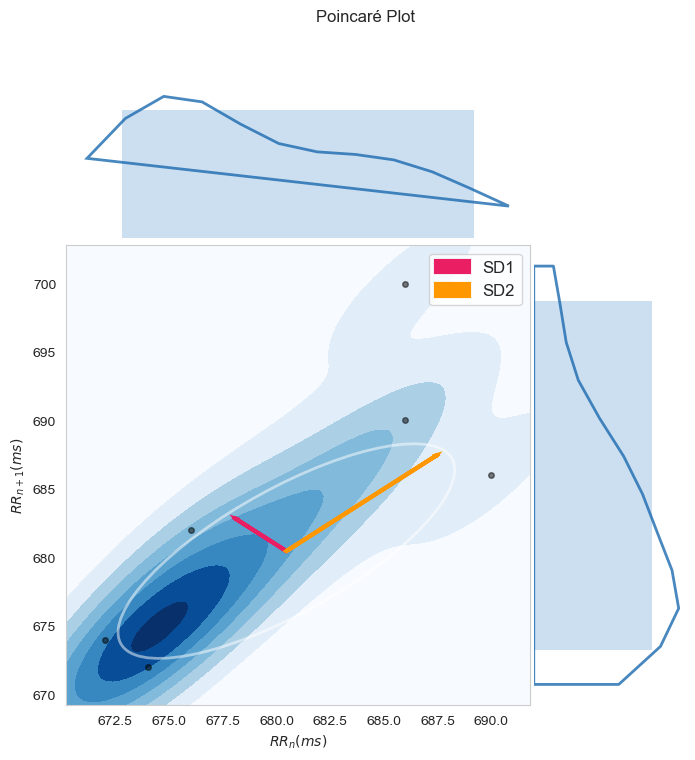

In [383]:
intr = nk.hrv_nonlinear(mi_df_rpeaks, sampling_rate=500, show=True)
dictionary=intr.iloc[0].to_dict()
display(dictionary)
plt.show()

In [187]:
rrr = np.diff(mi_map_rpeaks['ECG_R_Peaks']) * discret_time 
r_stat=r_timedomain(rrr)
r_stat

{'mean_(ms)': 680.4615384615385,
 'STD RR/SDNN (ms)': 7.928676139523154,
 "Mean HR (Kubios' style) (beats/min)": 88.17544652950487,
 'Mean HR (beats/min)': 88.18727642872776,
 'STD HR (beats/min)': 1.015355030393566,
 'Min HR (beats/min)': 85.71428571428571,
 'Max HR (beats/min)': 89.28571428571429,
 'RMSSD (ms)': 4.96655480858378,
 'NN50': 0,
 'pNN50 (%)': 0.0}

In [299]:
y_fold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21501 entries, 1 to 21837
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  21501 non-null  float64
 1   nurse                20056 non-null  object 
 2   site                 21486 non-null  object 
 3   device               21501 non-null  object 
 4   sex                  21501 non-null  int64  
 5   height               6812 non-null   float64
 6   weight               9263 non-null   float64
 7   heart_axis           13167 non-null  object 
 8   validated_by_human   21501 non-null  bool   
 9   pacemaker            283 non-null    object 
 10  electrodes_problems  29 non-null     object 
 11  burst_noise          603 non-null    object 
 12  static_noise         3215 non-null   object 
 13  baseline_drift       1570 non-null   object 
 14  NORM                 21501 non-null  int64  
 15  MI                   21501 non-null  int6

In [177]:
mi_map_rpeaks

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 307,  645,  982, 1319, 1656, 1992, 2329, 2667, 3008, 3349, 3692,
        4037, 4380, 4730]),
 'sampling_rate': 500}

In [91]:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


[-0.22610786 -0.22160621 -0.27549009 -0.28490867 -0.03992461 -0.18235143
  0.69906495  0.53925139 -0.18995355 -0.17998784  0.32905679  0.61720398
 -0.13949806 -0.2538277  -0.19872421 -0.20057138 -0.2465422 ]
Energy Level 0: 1.8537202600892213
Energy Level 1: 0.8814314804059199
Energy Level 2: 0.2853735516822576
Energy Level 3: 0.01853166953829086
Energy Level 4: 0.0013786893234645223
Energy Level 5: 9.052306705905126e-05


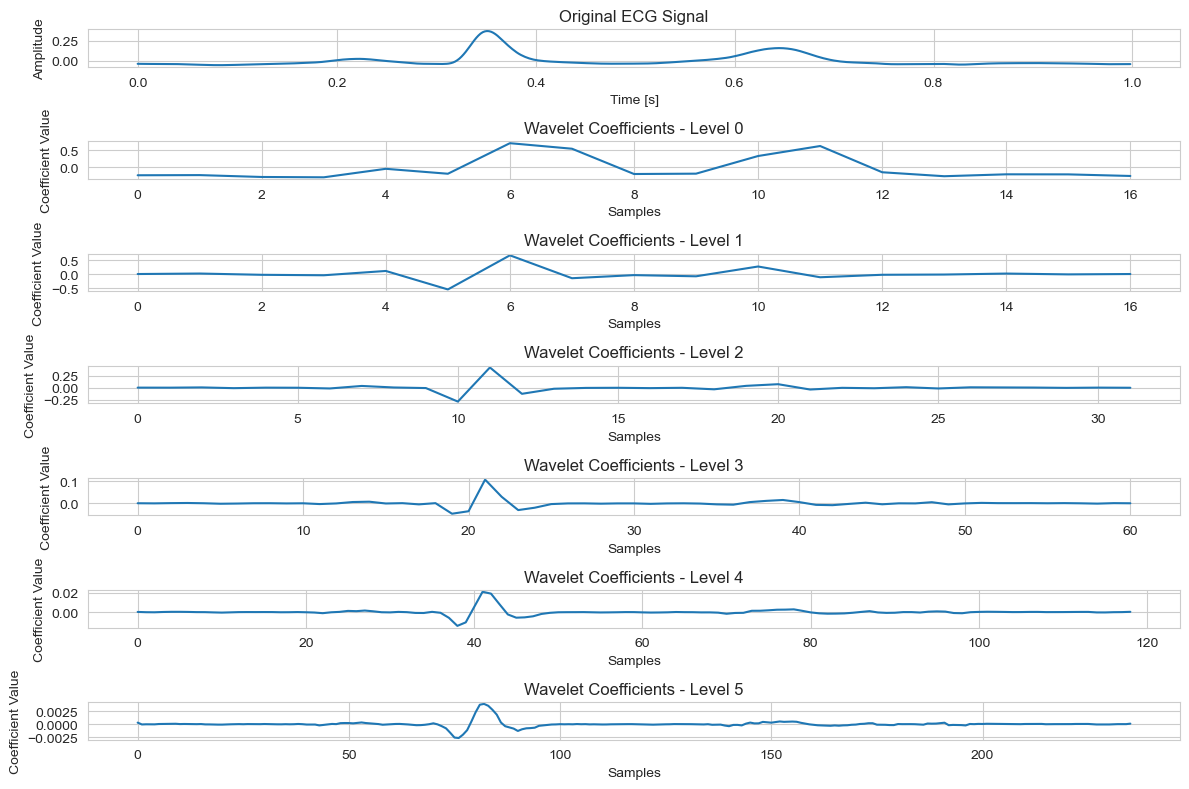

In [151]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Load your ECG data here
# For demonstration, we will create a synthetic ECG signal
# Replace this with your actual ECG data
fs = 500  # Sampling frequency in Hz
duration=1  
t = np.linspace(0, duration, l1, endpoint=False)
ecg_signal = norm_epochs['4']['Signal'].values  # Example ECG signal

# Wavelet transformation
wavelet = 'sym2'  # Choose the wavelet type (Morlet wavelet in this case)
coeffs = pywt.wavedec(ecg_signal, wavelet, level=5)  # Decompose the signal into wavelet coefficients
print(coeffs[0])

# Extract features from the wavelet coefficients
features = []
for i, coeff in enumerate(coeffs):
    # Calculate energy of each coefficient as a feature
    energy = np.sum(np.square(coeff))
    features.append(energy)

# Print extracted features
feature_names = [f'Energy Level {i}' for i in range(len(features))]
for name, value in zip(feature_names, features):
    print(f'{name}: {value}')

# Plotting the original ECG signal and its wavelet coefficients
plt.figure(figsize=(12, 8))

plt.subplot(len(coeffs) + 1, 1, 1)
plt.plot(t, ecg_signal)
plt.title('Original ECG Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs) + 1, 1, i + 2)
    plt.plot(coeff)
    plt.title(f'Wavelet Coefficients - Level {i}')
    plt.xlabel('Samples')
    plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()


magnitude=[9.39824364e-04 2.42401976e-02 9.66307464e-03 2.51836103e-02
 2.29452351e-02 9.79639968e-03 1.41366188e-02 1.87545245e-02
 1.12806797e-02 9.96242806e-03 1.12381415e-02 8.04529405e-03
 5.78049796e-03 6.90637188e-03 6.09046753e-03 4.76414229e-03
 4.45890983e-03 3.13968650e-03 2.86450224e-03 2.23491916e-03
 2.05114108e-03 1.62143122e-03 1.51828071e-03 1.12839525e-03
 8.57642809e-04 6.97193897e-04 7.64226900e-04 3.50028722e-04
 4.51220634e-04 2.54862007e-04 2.18748097e-04 1.09045034e-04
 9.90526614e-05 9.43783136e-05 4.76607143e-05 6.39436875e-05
 4.43707965e-05 9.56702054e-06 3.26895027e-05 7.19069247e-06]
frequencies=[ 0.          1.06382979  2.12765957  3.19148936  4.25531915  5.31914894
  6.38297872  7.44680851  8.5106383   9.57446809 10.63829787 11.70212766
 12.76595745 13.82978723 14.89361702 15.95744681 17.0212766  18.08510638
 19.14893617 20.21276596 21.27659574 22.34042553 23.40425532 24.46808511
 25.53191489 26.59574468 27.65957447 28.72340426 29.78723404 30.85106383
 3

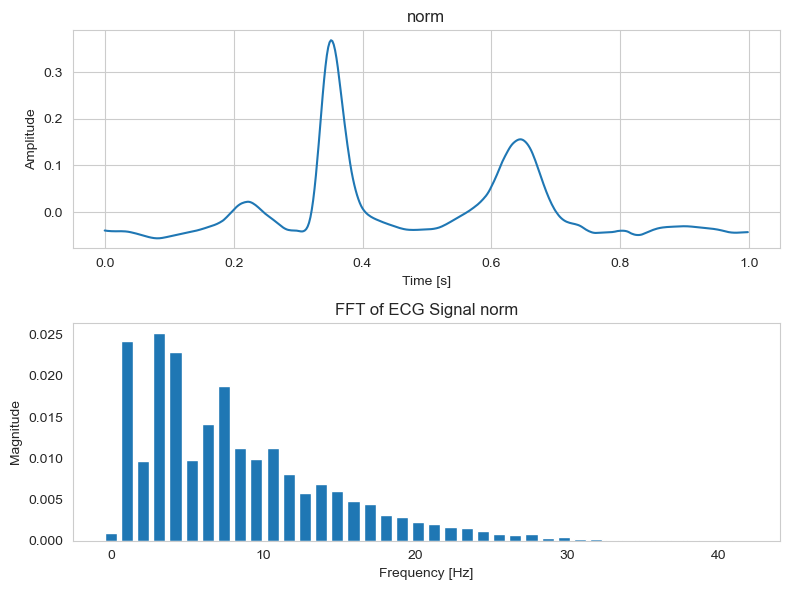

magnitude=[6.84443022e-04 3.35948102e-02 3.81580611e-02 1.98863950e-02
 3.47471876e-02 3.41603555e-02 3.08319963e-02 2.75519916e-02
 2.30063897e-02 2.29426788e-02 2.00103262e-02 1.82898109e-02
 1.54279254e-02 1.31218780e-02 1.10339746e-02 8.71677341e-03
 7.00446142e-03 5.49578580e-03 4.44108085e-03 3.42648706e-03
 2.47883821e-03 1.74582274e-03 1.05542625e-03 7.83071203e-04
 5.54545270e-04 3.46786915e-04 2.81163491e-04 8.79546742e-05
 7.72650109e-05 7.67648928e-05 3.19418444e-05 3.44444761e-05
 3.47723191e-05 3.13553197e-05 3.11695703e-05 3.09284829e-05
 3.04314203e-05 2.62370619e-05 3.74277239e-05 3.16201670e-05]
frequencies=[ 0.          1.46627566  2.93255132  4.39882698  5.86510264  7.3313783
  8.79765396 10.26392962 11.73020528 13.19648094 14.6627566  16.12903226
 17.59530792 19.06158358 20.52785924 21.9941349  23.46041056 24.92668622
 26.39296188 27.85923754 29.3255132  30.79178886 32.25806452 33.72434018
 35.19061584 36.6568915  38.12316716 39.58944282 41.05571848 42.52199413
 43

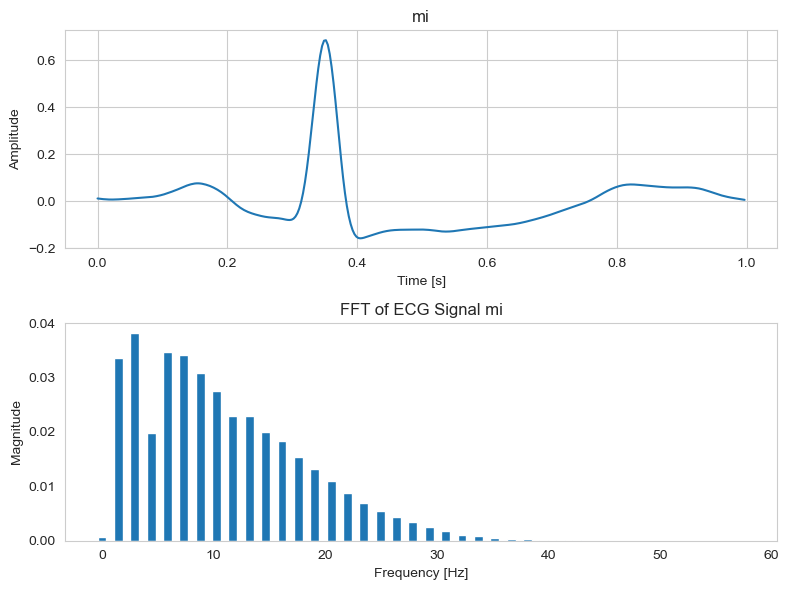

In [135]:
import numpy as np
import matplotlib.pyplot as plt

def make_fft(ecg_signal, samples, sampling_frequency=500, label=''):
# Constants
# Generate a sample ECG signal (for demonstration purposes)
# Replace this with your actual ECG data
  duration=1  
  t = np.linspace(0, duration, samples, endpoint=False)
#ecg_signal = sel_signal.values[:samples]  # Example ECG signal

# Perform FFT
  fft_result = np.fft.fft(ecg_signal)
  fft_magnitude = np.abs(fft_result) / samples  # Normalize the magnitude
  frequencies = np.fft.fftfreq(samples, d=1/sampling_frequency)
  print(f'magnitude={fft_magnitude[:40]}')
  print(f'frequencies={frequencies[:40]}')

# Plotting the results
  plt.figure(figsize=(8, 6))

# Plot the original ECG signal
  plt.subplot(2, 1, 1)
  plt.plot(t, ecg_signal)
  plt.title(label)
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude')

# Plot the FFT result
  plt.subplot(2, 1, 2)
  plt.bar(frequencies[:40], fft_magnitude[:40])  # Plot only positive frequencies
  plt.title('FFT of ECG Signal ' + label)
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Magnitude')
  plt.grid()

  plt.tight_layout()
  plt.show()

l1 = len(norm_epochs['4']['Signal'].values)
l2 = len(mi_epochs['4']['Signal'].values)
make_fft(ecg_signal=norm_epochs['4']['Signal'].values, samples=l1, sampling_frequency = 500, label='norm')
make_fft(ecg_signal=mi_epochs['4']['Signal'].values, samples=l2, sampling_frequency = 500, label='mi')
#samples = duration * sampling_frequency  # total number of samples
#  duration = 1  # duration of the signal in seconds

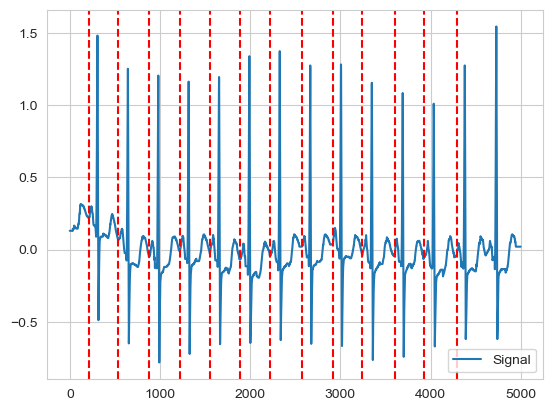

{'onset': array([ 298,  638,  975, 1312, 1648, 1984, 2321, 2660, 3000, 3342, 3685,
        4030, 4373, 4721]),
 'duration': array([16, 12, 12, 11, 13, 13, 13, 12, 13, 12, 11, 10, 12, 15]),
 'label': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14'], dtype='<U21')}

In [1500]:
events = nk.events_find(ecg_df[lead])

nk.events_plot(waves_peak['ECG_P_Onsets'], ecg_df[lead])
plt.show()
events

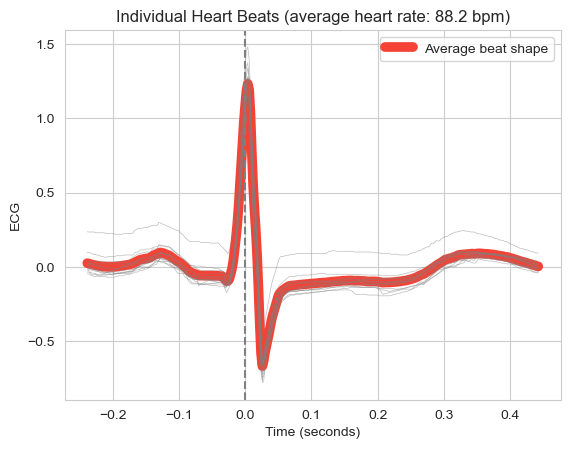

{'1':            Signal  Index Label
 -0.238175   0.236    186     1
 -0.236173   0.235    187     1
 -0.234172   0.235    188     1
 -0.232170   0.235    189     1
 -0.230169   0.235    190     1
 ...           ...    ...   ...
  0.434319   0.103    522     1
  0.436320   0.097    523     1
  0.438322   0.095    524     1
  0.440323   0.095    525     1
  0.442324   0.091    526     1
 
 [341 rows x 3 columns],
 '2':            Signal  Index Label
 -0.238175   0.097    523     2
 -0.236173   0.095    524     2
 -0.234172   0.095    525     2
 -0.232170   0.091    526     2
 -0.230169   0.086    527     2
 ...           ...    ...   ...
  0.434319   0.009    859     2
  0.436320   0.005    860     2
  0.438322   0.001    861     2
  0.440323  -0.003    862     2
  0.442324  -0.007    863     2
 
 [341 rows x 3 columns],
 '3':            Signal  Index Label
 -0.238175   0.005    860     3
 -0.236173   0.001    861     3
 -0.234172  -0.003    862     3
 -0.232170  -0.007    863     3
 -0

In [1502]:
epochs_1 = nk.ecg_segment(signals['ECG_Raw'], rpeaks=map_rpeaks['ECG_R_Peaks'], sampling_rate=500, show=True)
plt.show()
epochs_1

In [279]:
df_bio, info = nk.ecg_process(ecg_df[lead], sampling_rate=500)
events = nk.events_find(df_bio['ECG_Clean'])
epochs = nk.epochs_create(df_bio, events, sampling_rate=500, epochs_start=-0.1, epochs_end=1.9)
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=500)
analyze_epochs


NameError: name 'ecg_df' is not defined

In [558]:
events

{'onset': array([   0,  323,  661,  998, 1334, 1672, 2008, 2344, 2683, 3023, 3365,
        3708, 4053, 4396, 4745]),
 'duration': array([305, 320, 319, 319, 320, 318, 318, 320, 323, 324, 325, 327, 325,
        331, 255]),
 'label': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15'], dtype='<U21')}

In [560]:
ecg_df['V2']

0       0.045
1       0.045
2       0.045
3       0.045
4       0.045
        ...  
4995    0.105
4996    0.105
4997    0.105
4998    0.105
4999    0.105
Name: V2, Length: 5000, dtype: float64

In [562]:
events

{'onset': array([   0,  323,  661,  998, 1334, 1672, 2008, 2344, 2683, 3023, 3365,
        3708, 4053, 4396, 4745]),
 'duration': array([305, 320, 319, 319, 320, 318, 318, 320, 323, 324, 325, 327, 325,
        331, 255]),
 'label': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15'], dtype='<U21')}

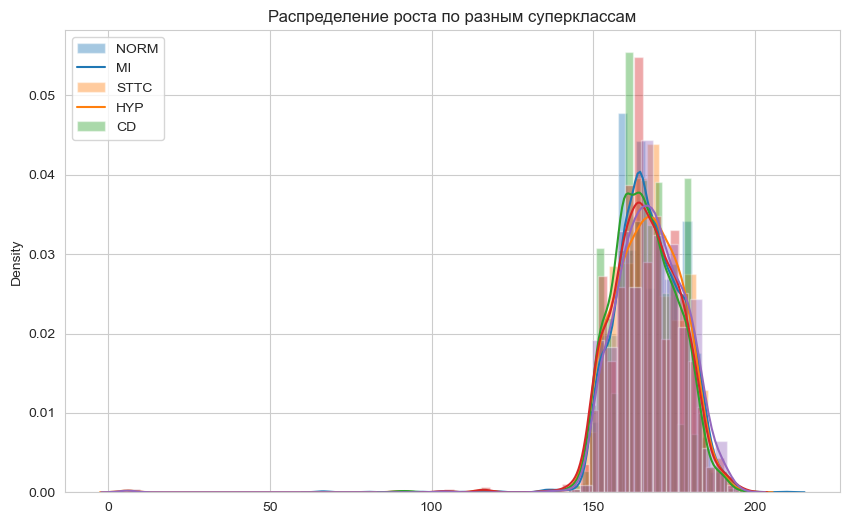

In [288]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Распределение роста по разным суперклассам')
for superclass in superclass_cols:
    data = y_fold.loc[y_fold[superclass] == 1][['height']]
    sns.distplot(data, label=superclass)

plt.legend(labels=superclass_cols, loc='upper left')
plt.show()

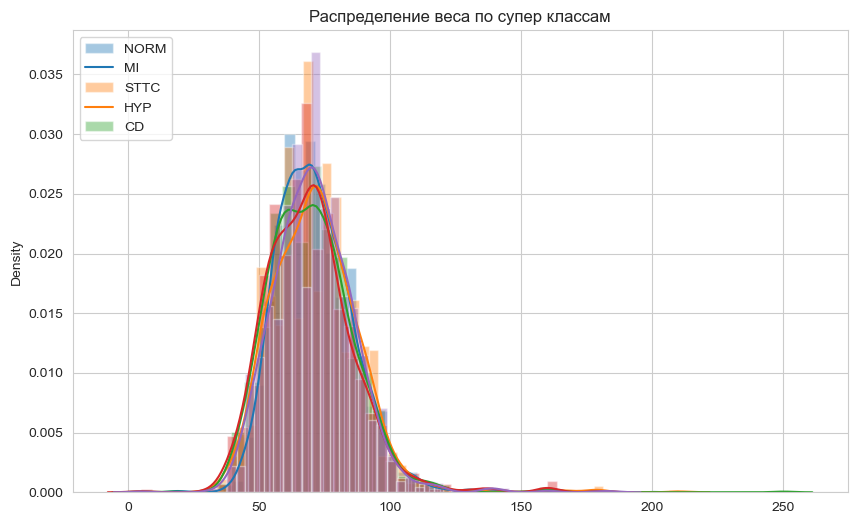

In [76]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Распределение веса по супер классам')
for superclass in superclass_cols:
    data = y_fold.loc[y_fold[superclass] == 1][['weight']]
    sns.distplot(data, label=superclass)

plt.legend(labels=superclass_cols, loc='upper left')
plt.show()

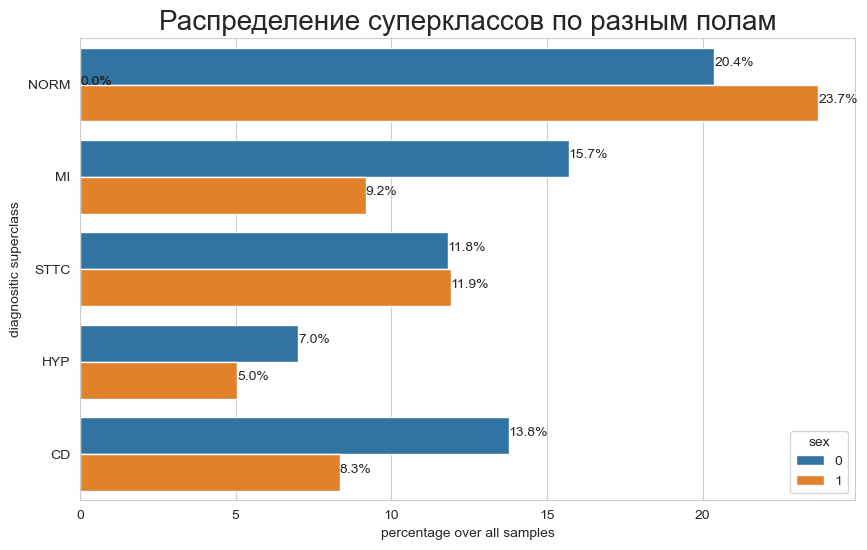

In [77]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
    
ax.set_title("Распределение суперклассов по разным полам", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_fold.sex.unique():
    vc = y_fold.loc[y_fold.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['sex'] = all_values
    
ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="sex", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()    

0 - мужчина, 1 - женщина. Видно, что MI присутствует у 15 процентов мужчин, против 9 процентов женщин.

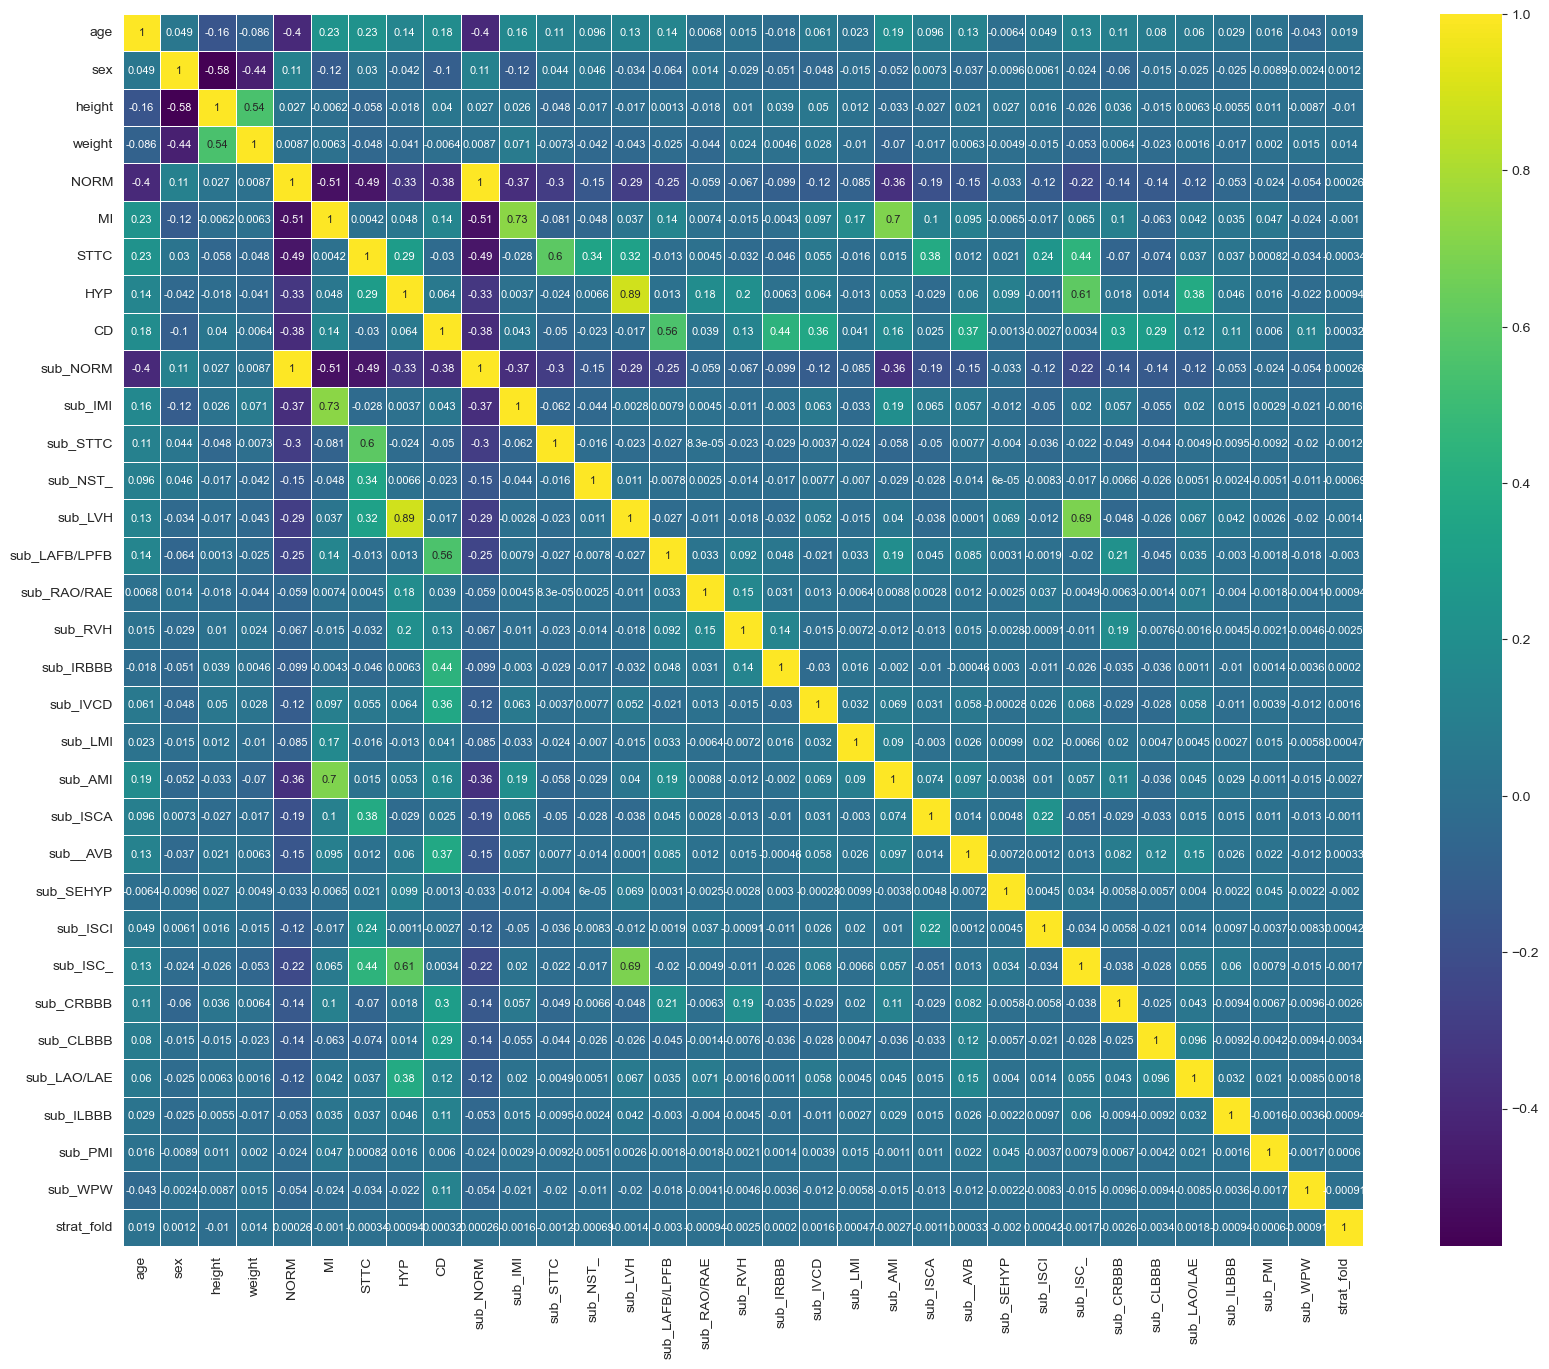

In [115]:
plt.figure(figsize = (20,16))
sns.heatmap(y_fold.corr(numeric_only=True),
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white", annot_kws = {'size':8})
plt.show()

In [80]:
corr_matrix = y_fold.corr(numeric_only=True)
corr_unstacked = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
sorted_corr_pairs = corr_unstacked.abs().sort_values(ascending=False)
most_correlated_pairs = corr_unstacked[sorted_corr_pairs.index]
most_correlated_pairs.head(20)

NORM     sub_NORM         1.000000
HYP      sub_LVH          0.885565
MI       sub_IMI          0.728989
         sub_AMI          0.697662
sub_LVH  sub_ISC_         0.687792
HYP      sub_ISC_         0.610587
STTC     sub_STTC         0.603370
sex      height          -0.576090
CD       sub_LAFB/LPFB    0.555745
height   weight           0.544532
NORM     MI              -0.510714
MI       sub_NORM        -0.510714
NORM     STTC            -0.487825
STTC     sub_NORM        -0.487825
         sub_ISC_         0.443317
sex      weight          -0.435627
CD       sub_IRBBB        0.435078
age      sub_NORM        -0.396664
         NORM            -0.396664
HYP      sub_LAO/LAE      0.379847
dtype: float64

In [119]:
y_fold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21501 entries, 1 to 21837
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            21501 non-null  float64
 1   nurse          20056 non-null  object 
 2   site           21486 non-null  object 
 3   device         21501 non-null  object 
 4   sex            21501 non-null  int64  
 5   height         6812 non-null   float64
 6   weight         9263 non-null   float64
 7   NORM           21501 non-null  int64  
 8   MI             21501 non-null  int64  
 9   STTC           21501 non-null  int64  
 10  HYP            21501 non-null  int64  
 11  CD             21501 non-null  int64  
 12  sub_NORM       21501 non-null  int64  
 13  sub_IMI        21501 non-null  int64  
 14  sub_STTC       21501 non-null  int64  
 15  sub_NST_       21501 non-null  int64  
 16  sub_LVH        21501 non-null  int64  
 17  sub_LAFB/LPFB  21501 non-null  int64  
 18  sub_RAO/RAE

In [121]:
y_fold

age nurse site      device  sex  height  weight  NORM  MI  STTC  HYP  \
ecg_id                                                                          
1       56.0     2    0   CS-12   E    1     NaN    63.0     1   0     0    0   
2       19.0     2    0   CS-12   E    0     NaN    70.0     1   0     0    0   
3       37.0     2    0   CS-12   E    1     NaN    69.0     1   0     0    0   
4       24.0     2    0   CS-12   E    0     NaN    82.0     1   0     0    0   
5       19.0     2    0   CS-12   E    1     NaN    70.0     1   0     0    0   
...      ...   ...  ...         ...  ...     ...     ...   ...  ..   ...  ...   
21832   63.0     1    2  AT-60    3    0     NaN     NaN     0   0     0    0   
21833   67.0     1    2  AT-60    3    1     NaN     NaN     0   0     1    0   
21835   59.0     1    2  AT-60    3    1     NaN     NaN     0   0     1    0   
21836   64.0     1    2  AT-60    3    1     NaN     NaN     1   0     0    0   
21837   68.0     1    2  AT-60    3    0     NaN     NaN     1   0     0    0   

        CD  sub_NORM  sub_IMI  sub_STTC  sub_NST_  sub_LVH  sub_LAFB/LPFB  \
ecg_id                                                                      
1        0         1        0         0         0        0              0   
2        0         1        0         0         0        0              0   
3        0         1        0         0         0        0              0   
4        0         1        0         0         0        0              0   
5        0         1        0         0         0        0              0   
...     ..       ...      ...       ...       ...      ...            ...   
21832    1         0        0         0         0        0              1   
21833    0         0        0         1         0        0              0   
21835    0         0        0         0         0        0              0   
21836    0         1        0         0         0        0              0   
21837    0         1        0         0         0        0              0   

        sub_RAO/RAE  sub_RVH  sub_IRBBB  sub_IVCD  sub_LMI  sub_AMI  sub_ISCA  \
ecg_id                                                                          
1                 0        0          0         0        0        0         0   
2                 0        0          0         0        0        0         0   
3                 0        0          0         0        0        0         0   
4                 0        0          0         0        0        0         0   
5                 0        0          0         0        0        0         0   
...             ...      ...        ...       ...      ...      ...       ...   
21832             0        0          0         1        0        0         0   
21833             0        0          0         0        0        0         0   
21835             0        0          0         0        0        0         1   
21836             0        0          0         0        0        0         0   
21837             0        0          0         0        0        0         0   

        sub__AVB  sub_SEHYP  sub_ISCI  sub_ISC_  sub_CRBBB  sub_CLBBB  \
ecg_id                                                                  
1              0          0         0         0          0          0   
2              0          0         0         0          0          0   
3              0          0         0         0          0          0   
4              0          0         0         0          0          0   
5              0          0         0         0          0          0   
...          ...        ...       ...       ...        ...        ...   
21832          0          0         0         0          0          0   
21833          0          0         0         0          0          0   
21835          0          0         0         0          0          0   
21836          0          0         0         0          0          0   
21837          0       

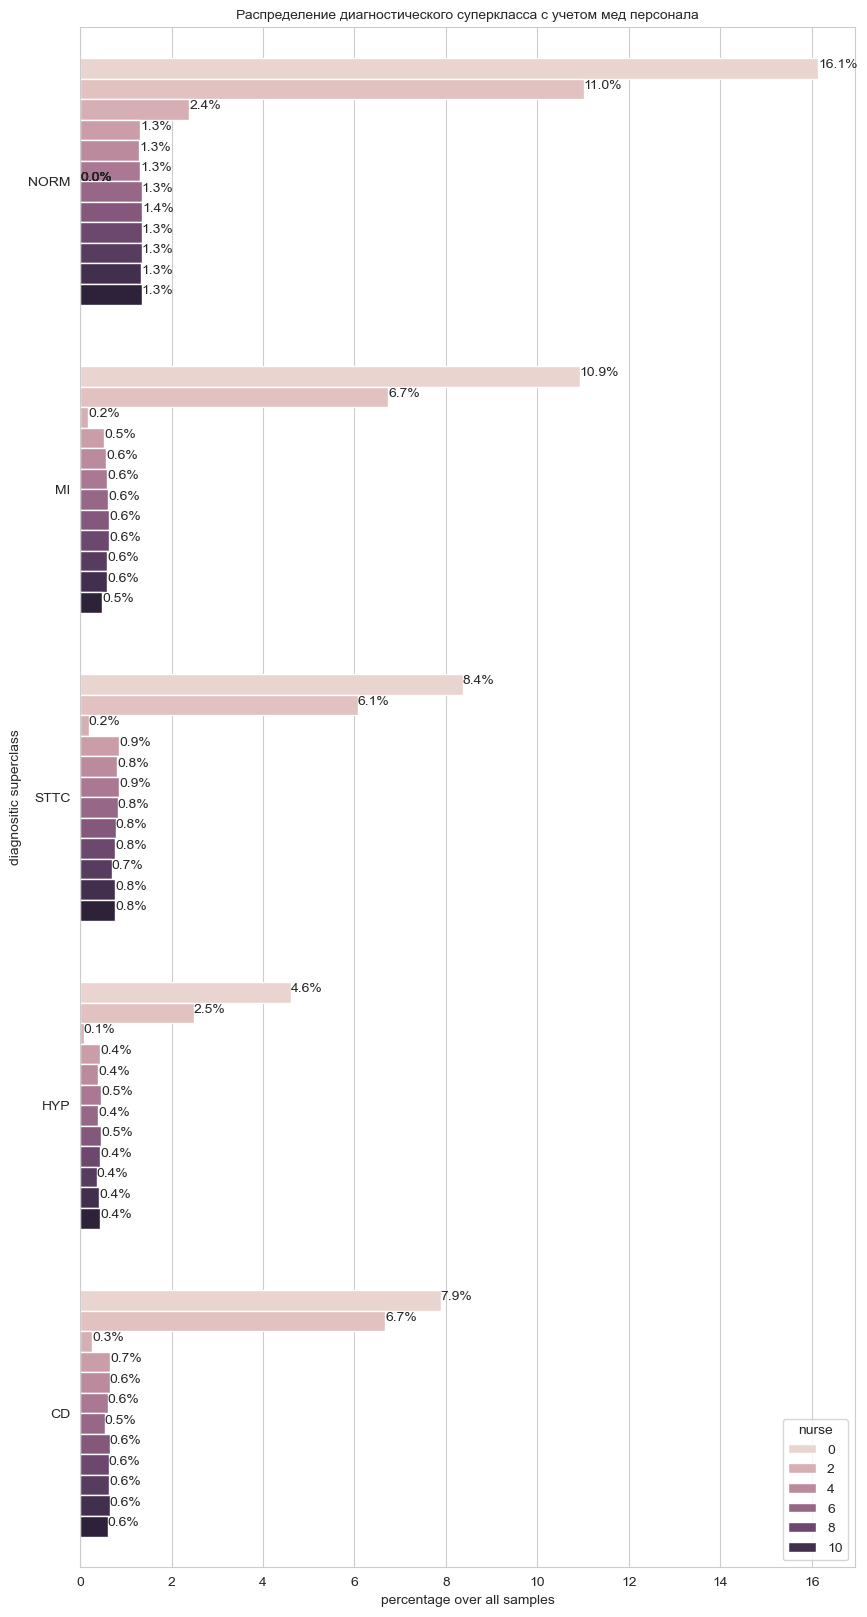

In [87]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Распределение диагностического суперкласса с учетом мед персонала", fontsize=10)

all_index, all_count, all_values = [], [], []
for nurse in y_fold.nurse.unique():
    vc = y_fold.loc[y_fold.nurse == nurse][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [nurse]*len(vc)
    #print(all_sex)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['nurse'] = all_values
    
ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="nurse", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width())
plt.show()     

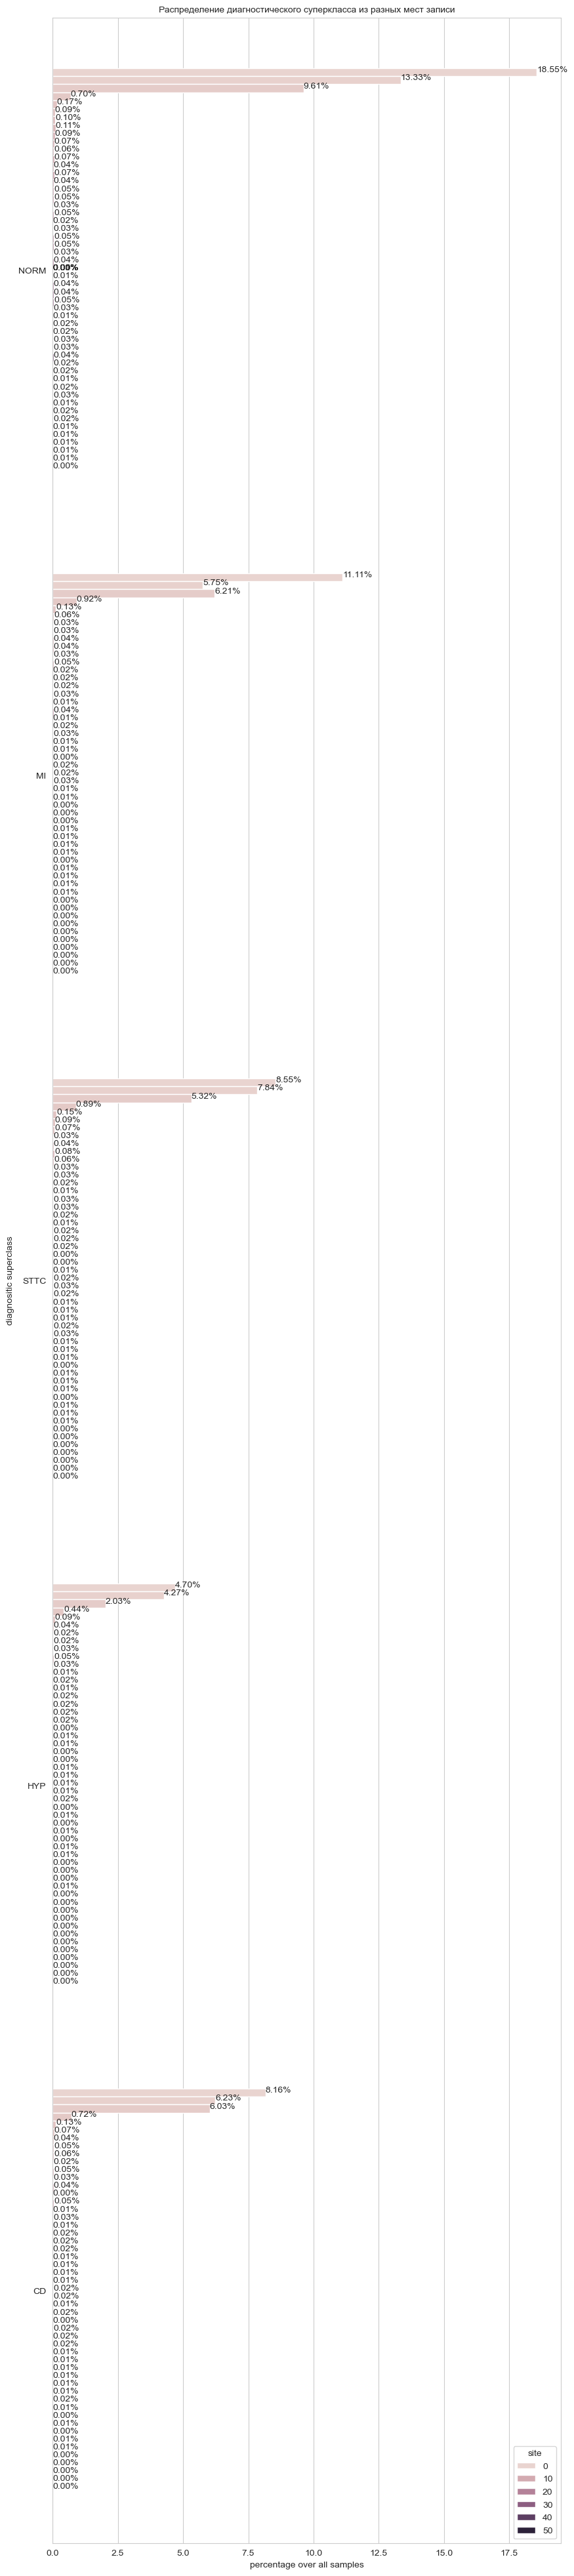

In [89]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,50))    
ax.set_title("Распределение диагностического суперкласса из разных мест записи", fontsize=10)

all_index, all_count, all_values = [], [], []
for site in y_fold.site.unique():
    vc = y_fold.loc[y_fold.site == site][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [site]*len(vc)
    #print(all_sex)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['site'] = all_values
    
ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="site", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width())
plt.show()     

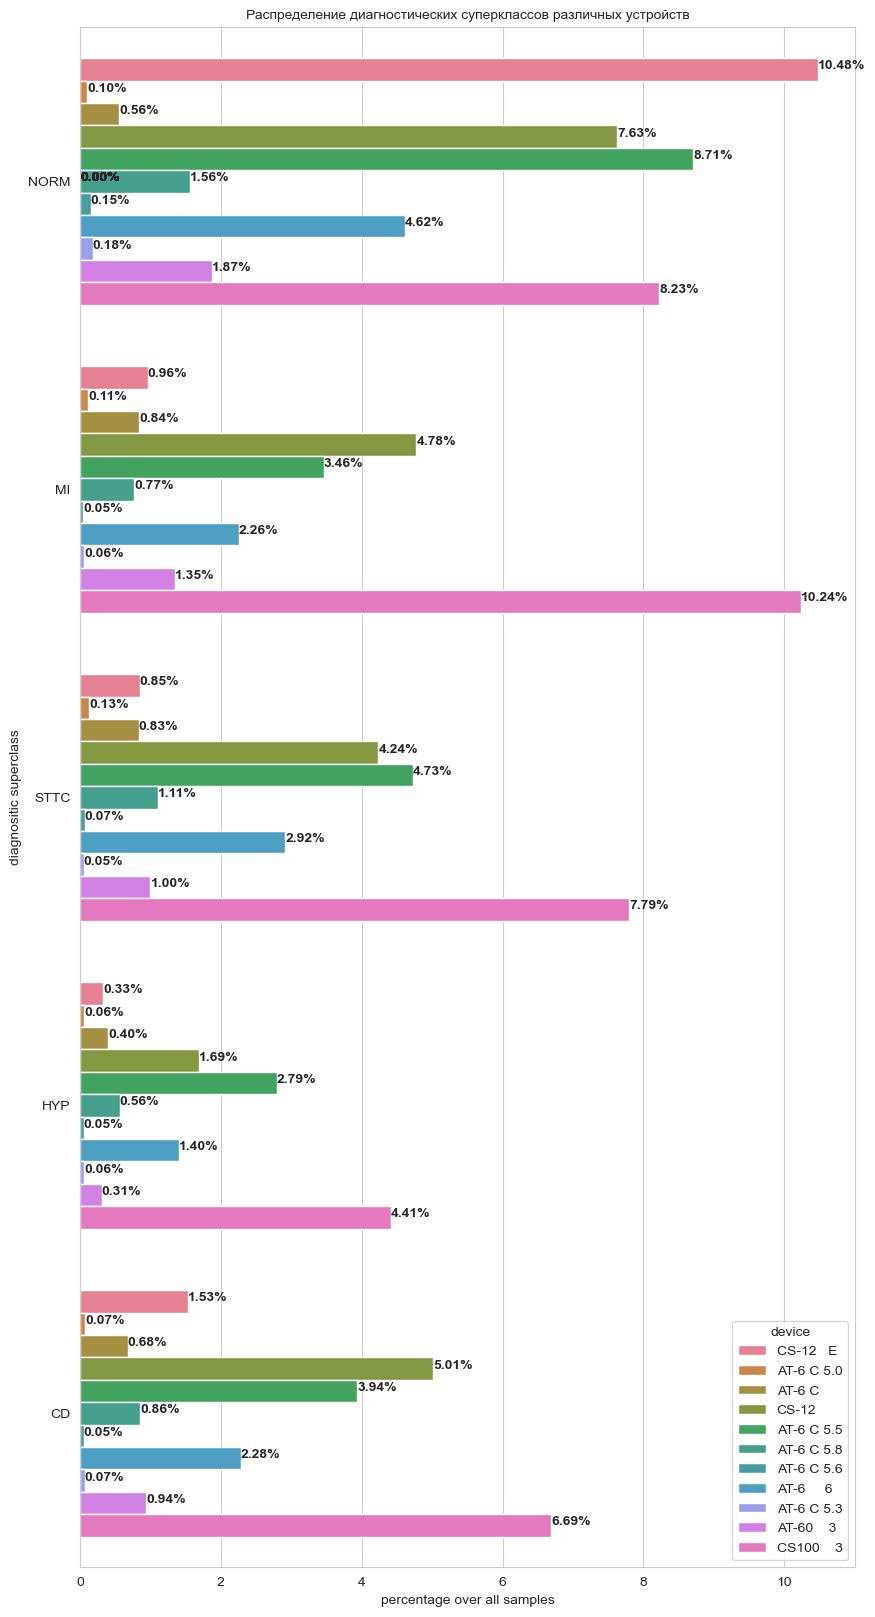

In [91]:

bar,ax = plt.subplots(figsize=(10,20))    
ax.set_title("Распределение диагностических суперклассов различных устройств", fontsize=10)
all_index, all_count, all_values = [], [], []
for device in y_fold.device.unique():
    vc = y_fold.loc[y_fold.device == device][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_fold.shape[0]*100.)
    all_values += [device]*len(vc)
    
tmp_df = pd.DataFrame()
tmp_df['diagnositic superclass'] = all_index
tmp_df['percentage over all samples'] = all_count
tmp_df['device'] = all_values

ax = sns.barplot(data=tmp_df, x="percentage over all samples", y="diagnositic superclass", hue="device", orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')
plt.show()    

In [93]:
!pip install missingno

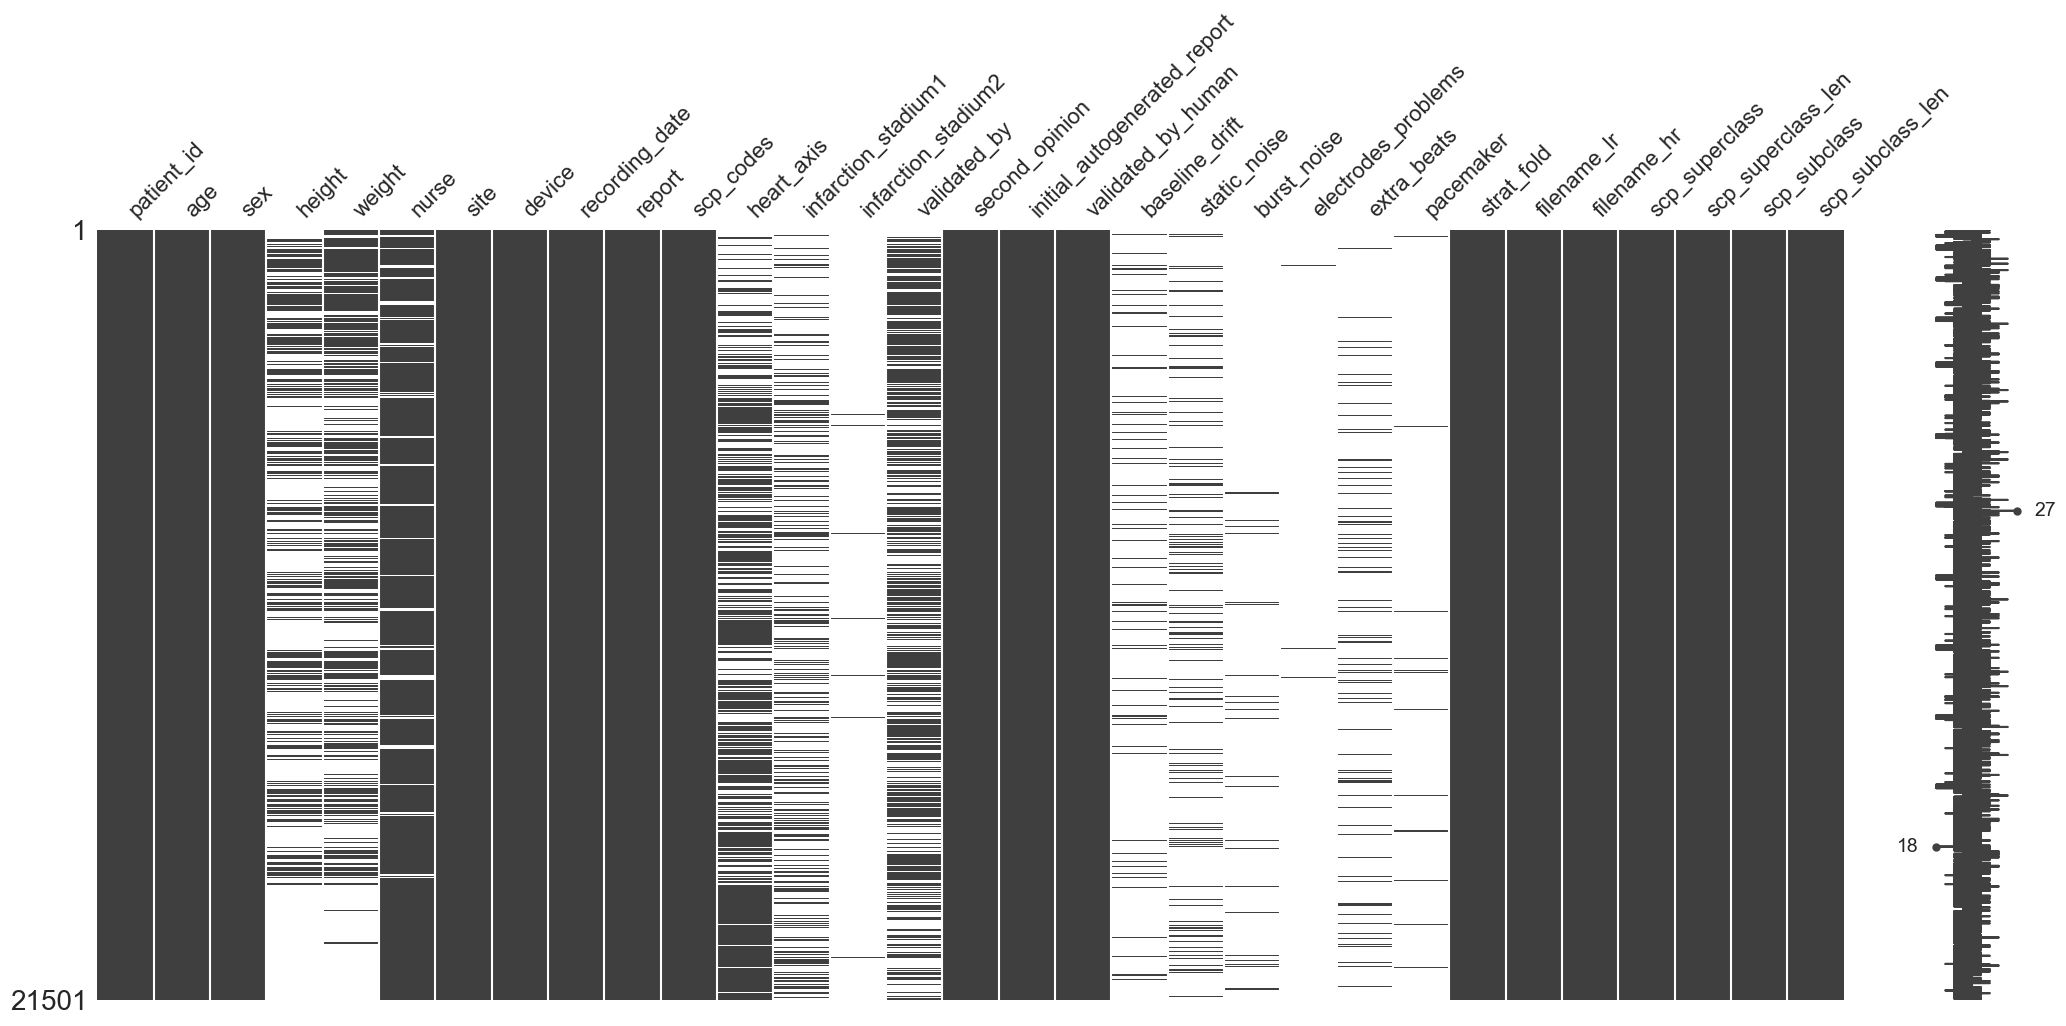

In [95]:
import missingno as msno

msno.matrix(df)
plt.show()

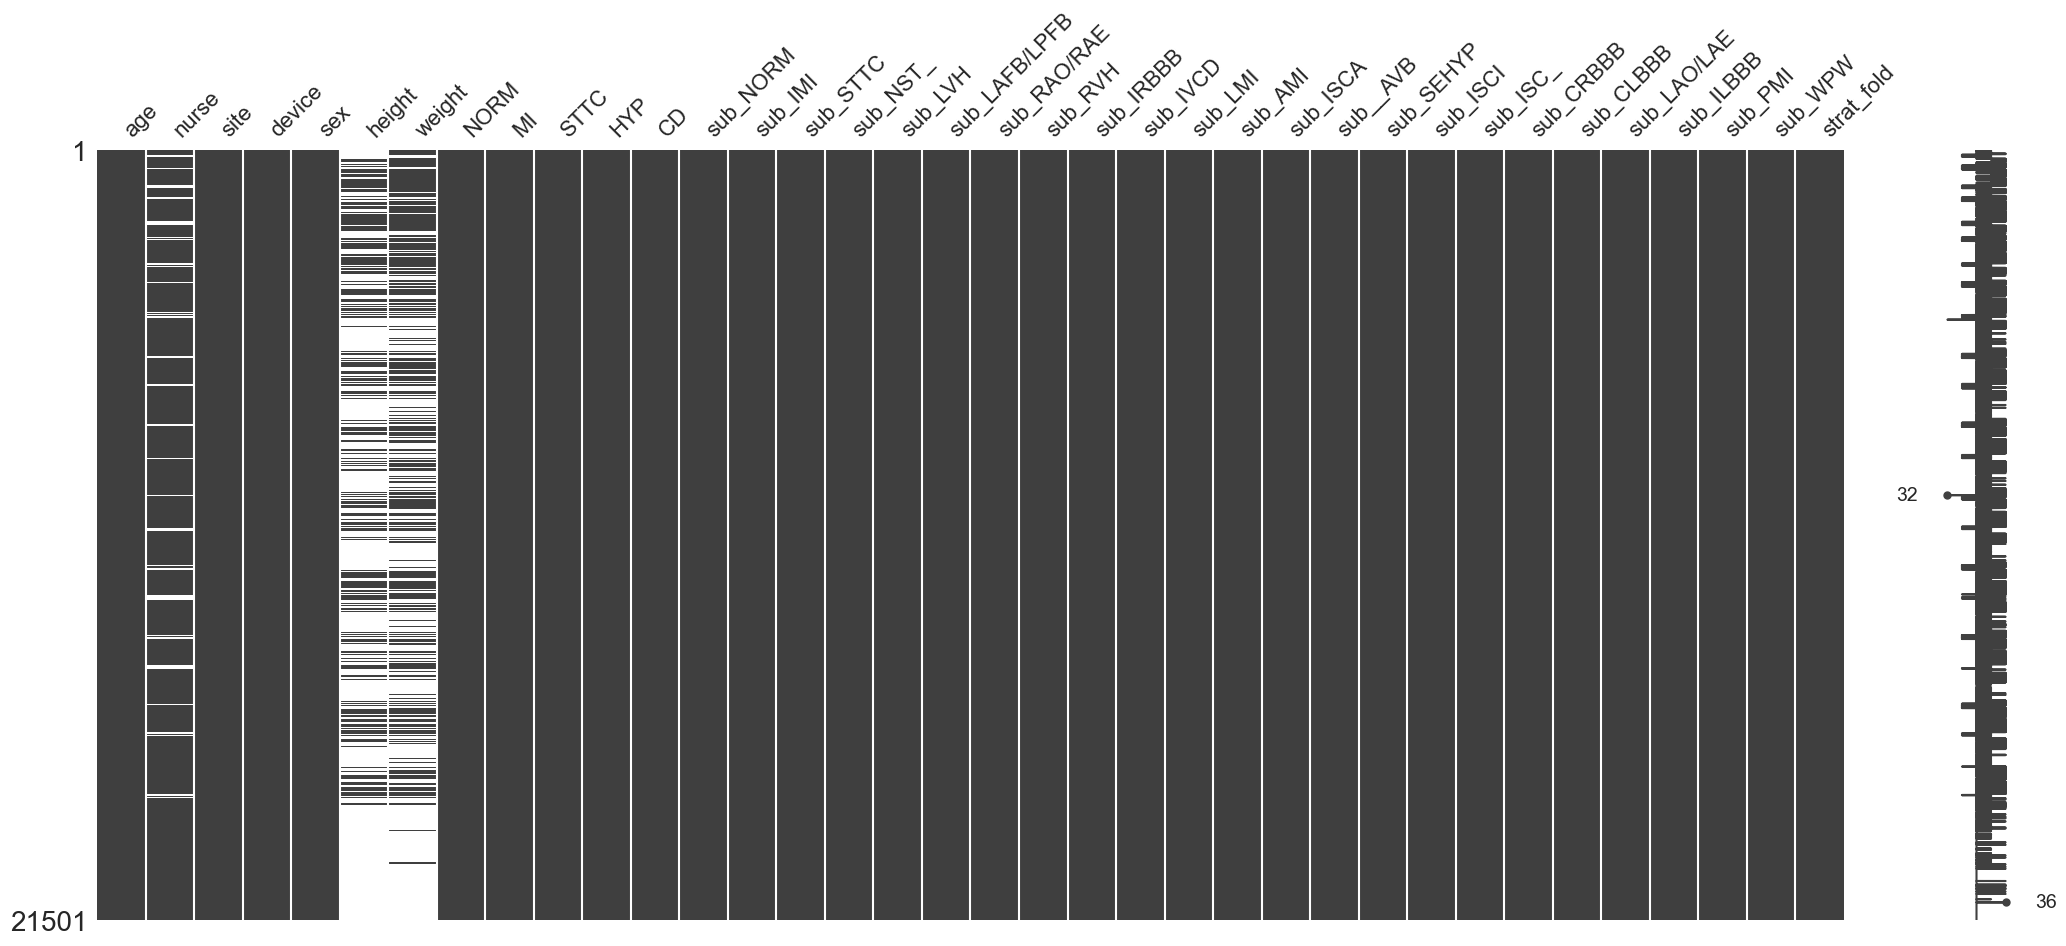

In [97]:
import missingno as msno

msno.matrix(y_fold)
plt.show()

In [99]:
pd.set_option('display.max_columns', None)

In [101]:
df.head(5)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1            15709  56.0    1     NaN    63.0      2     0  CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0  CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0  CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0  CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0  CS-12   E   

             recording_date                                  report  \
ecg_id                                                                
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg   

                                       scp_codes heart_axis  \
ecg_id                                                        
1       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN   
2                   {'NORM': 80.0, 'SBRAD': 0.0}        NaN   
3                     {'NORM': 100.0, 'SR': 0.0}        NaN   
4                     {'NORM': 100.0, 'SR': 0.0}        NaN   
5                     {'NORM': 100.0, 'SR': 0.0}        NaN   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
1                      NaN                 NaN          <NA>           False   
2                      NaN                 NaN          <NA>           False   
3                      NaN                 NaN          <NA>           False   
4                      NaN                 NaN          <NA>           False   
5                      NaN                 NaN          <NA>           False   

        initial_autogenerated_report  validated_by_human  baseline_drift  \
ecg_id                                                                     
1                              False                True             NaN   
2                              False                True             NaN   
3                              False                True             NaN   
4                              False                True    , II,III,AVF   
5                              False                True   , III,AVR,AVF   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
1         , I-V1,           NaN                 NaN         NaN       NaN   
2               NaN         NaN                 NaN         NaN       NaN   
3               NaN         NaN                 NaN         NaN       NaN   
4               NaN         NaN                 NaN         NaN       NaN   
5               NaN         NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  \
ecg_id                                                                     
1                3  records100/00000/00001_lr  records500/00000/00001_hr   
2                2  records100/00000/00002_lr  records500/00000/00002_hr   
3                5  records100/00000/00003_lr  records500/00000/00003_hr   
4                3  records100/00000/00004_lr  records500/00000/00004_hr   
5                4  records100/00000/00005_lr  records500/00000/00005_hr   

       scp_superclass  scp_superclass_len scp_subclass  scp_subclass_len  
ecg_id                                                                    
1              [NORM]                   1   [sub_NORM]                 1  
2              [NORM]                   1   [sub_NORM]                 1  
3              [NORM]                   1   [sub_NORM]                 1  
4             

In [111]:
!pwd

/Users/echmel/hse/developmenttools/yp20


In [113]:
df[[col for col in df.columns if col not in ('scp_superclass','scp_codes', 'scp_subclass')]].nunique(dropna=True)

patient_id                      18607
age                                85
sex                                 2
height                             74
weight                            124
nurse                              12
site                               51
device                             11
recording_date                  21497
report                           9670
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    312
static_noise                      122
burst_noise                       102
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21501
filename_hr                     21501
scp_supercla

In [123]:
df

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1            15709  56.0    1     NaN    63.0      2     0   CS-12   E   
2            13243  19.0    0     NaN    70.0      2     0   CS-12   E   
3            20372  37.0    1     NaN    69.0      2     0   CS-12   E   
4            17014  24.0    0     NaN    82.0      2     0   CS-12   E   
5            17448  19.0    1     NaN    70.0      2     0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21832         7954  63.0    0     NaN     NaN      1     2  AT-60    3   
21833        17180  67.0    1     NaN     NaN      1     2  AT-60    3   
21835        19311  59.0    1     NaN     NaN      1     2  AT-60    3   
21836         8873  64.0    1     NaN     NaN      1     2  AT-60    3   
21837        11744  68.0    0     NaN     NaN      1     2  AT-60    3   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
...                     ...   
21832   2001-05-30 14:14:25   
21833   2001-05-31 09:14:35   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  \
ecg_id                                                      
1                  sinusrhythmus periphere niederspannung   
2                     sinusbradykardie sonst normales ekg   
3                              sinusrhythmus normales ekg   
4                              sinusrhythmus normales ekg   
5                              sinusrhythmus normales ekg   
...                                                   ...   
21832   sinusrhythmus linkstyp periphere niederspannun...   
21833   ventrikulÄre extrasystole(n) sinustachykardie ...   
21835   sinusrhythmus lagetyp normal t abnorm in anter...   
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...   

                                                scp_codes heart_axis  \
ecg_id                                                                 
1                {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN   
2                            {'NORM': 80.0, 'SBRAD': 0.0}        NaN   
3                              {'NORM': 100.0, 'SR': 0.0}        NaN   
4                              {'NORM': 100.0, 'SR': 0.0}        NaN   
5                              {'NORM': 100.0, 'SR': 0.0}        NaN   
...                                                   ...        ...   
21832           {'LAFB': 100.0, 'IVCD': 100.0, 'SR': 0.0}        LAD   
21833   {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...        LAD   
21835                          {'ISCAS': 50.0, 'SR': 0.0}        MID   
21836                          {'NORM': 100.0, 'SR': 0.0}        LAD   
21837                          {'NORM': 100.0, 'SR': 0.0}        MID   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
1                      NaN                 NaN          <NA>           False   
2                      NaN                 NaN          <NA>           False   
3                      NaN                 NaN          <NA>           False   
4                      NaN                 NaN          <NA>           False   
5                      NaN                 NaN          <NA>           False   
...                    ...                 ...           ...             ...   
21832                  NaN                 NaN             1           False   
21833                  NaN                 NaN             1           False   
21835                  NaN                 NaN             1            True   
21836                  NaN    

In [107]:
y_fold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21501 entries, 1 to 21837
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            21501 non-null  float64
 1   nurse          20056 non-null  object 
 2   site           21486 non-null  object 
 3   device         21501 non-null  object 
 4   sex            21501 non-null  int64  
 5   height         6812 non-null   float64
 6   weight         9263 non-null   float64
 7   NORM           21501 non-null  int64  
 8   MI             21501 non-null  int64  
 9   STTC           21501 non-null  int64  
 10  HYP            21501 non-null  int64  
 11  CD             21501 non-null  int64  
 12  sub_NORM       21501 non-null  int64  
 13  sub_IMI        21501 non-null  int64  
 14  sub_STTC       21501 non-null  int64  
 15  sub_NST_       21501 non-null  int64  
 16  sub_LVH        21501 non-null  int64  
 17  sub_LAFB/LPFB  21501 non-null  int64  
 18  sub_RAO/RAE

In [109]:
y_fold.nunique(dropna=True)

age               85
nurse             12
site              51
device            11
sex                2
height            74
weight           124
NORM               2
MI                 2
STTC               2
HYP                2
CD                 2
sub_NORM           2
sub_IMI            2
sub_STTC           2
sub_NST_           2
sub_LVH            2
sub_LAFB/LPFB      2
sub_RAO/RAE        2
sub_RVH            2
sub_IRBBB          2
sub_IVCD           2
sub_LMI            2
sub_AMI            2
sub_ISCA           2
sub__AVB           2
sub_SEHYP          2
sub_ISCI           2
sub_ISC_           2
sub_CRBBB          2
sub_CLBBB          2
sub_LAO/LAE        2
sub_ILBBB          2
sub_PMI            2
sub_WPW            2
strat_fold        10
dtype: int64